# Reproduction of a paper on NYC Property Tax Record Fraud Detection using Unsupervised learning models

**PDF of the paper here:** https://github.com/mrinal1704/NYC-Property-Tax-Record-Fraud-Detection-using-Unsupervised-learning-models/blob/master/NYC%20Property%20Fraud%20Detection%20Report.pdf

**Original Jupyter Notebook here:** https://github.com/mrinal1704/NYC-Property-Tax-Record-Fraud-Detection-using-Unsupervised-learning-models/blob/master/NYC%20Property%20Tax%20Fraud%20Detection.ipynb

**My exercise developed on Kaggle** https://www.kaggle.com/code/danwilshere/notebookb0c527419f

Notes on this specific version: 
 - The original work was done back in ~2020, and the authors left a note that the NYC dataset was updated by the city publishers in 2018, and there is some small variance between the original study results and what I found here so there may have been another update in between
 - Some libraries have also evolved, and there were some inefficiencies in the original code that I've updated so it runs faster and uses less memory
 - My results are very similar in this exercise, which they call fraud detection, but it really outlier detection. I think fraud detection would involve identifying attributes that contribute to actual fraud; that is, an intent to underpay the taxes owed.

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from copy import deepcopy
import datetime as dt
from sklearn import preprocessing
from sklearn.decomposition import PCA
from scipy.linalg import norm
from pprint import pp as pprint 

from keras.layers import Input, Dense
from keras.models import Model

# set the global pandas options to suppress scientific notation
pd.options.display.float_format = '{:,.0f}'.format
# allow all columns to be shown for EDA & other inquiries
pd.options.display.max_columns = 999

In [2]:
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/nyc-avroll-2010-2011-csv/avroll.csv


## First load the data and perform some EDA

**Original data** from here: https://data.cityofnewyork.us/City-Government/Property-Valuation-and-Assessment-Data-Tax-Classes/8y4t-faws/about_data

I've exported the access data table there to a CSV file and uploaded it here

In [3]:
start_time = dt.datetime.now()
print(f"Code run start time: {start_time}")

df_raw = pd.read_csv('/kaggle/input/nyc-avroll-2010-2011-csv/avroll.csv')
df_raw

Code run start time: 2024-12-12 07:16:47.950385


,BBLE,B,BLOCK,LOT,EASEMENT,OWNER,BLDGCL,TAXCLASS,LTFRONT,LTDEPTH,EXT,STORIES,FULLVAL,AVLAND,AVTOT,EXLAND,EXTOT,EXCD1,STADDR,ZIP,EXMPTCL,BLDFRONT,BLDDEPTH,AVLAND2,AVTOT2,EXLAND2,EXTOT2,EXCD2,PERIOD,YEAR,VALTYPE
0,1000010010,1,1,10,NaN,UNITED STATES OF AMER,Y4,4,198,0,NaN,NaN,304042000,96228900,136818900,96228900,136818900,"4,500",1 GOVERNORS ISLAND,"10,004",X3,0,0,"81,732,780","120,846,780","81,732,780","120,846,780",NaN,FINAL,2010/11,AC-TR
1,1000010101,1,1,101,NaN,U S GOVT LAND & BLDGS,P7,4,500,1046,NaN,NaN,21400000,4225500,9630000,4225500,9630000,"4,600",1 LIBERTY ISLAND,"10,004",X3,0,0,"3,775,500","8,613,000","3,775,500","8,613,000",NaN,FINAL,2010/11,AC-TR
2,1000010201,1,1,201,NaN,U S GOVT LAND & BLDGS,Z9,4,27,0,NaN,NaN,193800000,14310000,87210000,14310000,87210000,"4,600",1 ELLIS ISLAND,"10,004",X3,0,0,"11,111,400","80,690,400","11,111,400","80,690,400",NaN,FINAL,2010/11,AC-TR
3,1000020001,1,2,1,NaN,DEPT OF GENERAL SERVI,Y7,4,709,564,E,3,104686000,39008700,47108700,39008700,47108700,"2,191",MARGINAL STREET,"10,004",X1,709,564,"32,321,790","40,179,510","32,321,790","40,179,510",NaN,FINAL,2010/11,AC-TR
4,1000020023,1,2,23,NaN,DEPARTMENT OF BUSINES,T2,4,793,551,NaN,2,39200000,15255000,17640000,15255000,17640000,"2,191",PIER 6,"10,004",X1,85,551,"13,644,000","15,750,000","13,644,000","15,750,000",NaN,FINAL,2010/11,AC-TR
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1048570,5060270026,5,6027,26,NaN,HASAN DJUKANOVIC,A9,1,18,70,NaN,2,257000,7981,12820,1620,1620,"1,017",1946 ARTHUR KILL ROAD,"10,312",NaN,18,28,NaN,NaN,NaN,NaN,NaN,FINAL,2010/11,AC-TR
1048571,5060270027,5,6027,27,NaN,GRACE G BUONO,A9,1,24,70,NaN,2,275100,9341,14042,0,0,NaN,1948 ARTHUR KILL ROAD,"10,312",NaN,24,24,NaN,NaN,NaN,NaN,NaN,FINAL,2010/11,AC-TR
1048572,5060270028,5,6027,28,NaN,WALTER ACIERTO,A5,1,24,70,NaN,2,275100,9341,14042,1620,1620,"1,017",1950 ARTHUR KILL ROAD,"10,312",NaN,24,24,NaN,NaN,NaN,NaN,NaN,FINAL,2010/11,AC-TR
1048573,5060270029,5,6027,29,NaN,RICHARD P. DEVLIN,A5,1,18,70,NaN,2,257000,7981,12820,1620,1620,"1,017",1952 ARTHUR KILL ROAD,"10,312",NaN,18,28,NaN,NaN,NaN,NaN,NaN,FINAL,2010/11,AC-TR


In [4]:
df_raw.describe()

,B,BLOCK,LOT,LTFRONT,LTDEPTH,STORIES,FULLVAL,AVLAND,AVTOT,EXLAND,EXTOT,EXCD1,ZIP,BLDFRONT,BLDDEPTH,AVLAND2,AVTOT2,EXLAND2,EXTOT2,EXCD2
count,"1,048,575","1,048,575","1,048,575","1,048,575","1,048,575","996,433","1,048,575","1,048,575","1,048,575","1,048,575","1,048,575","622,642","1,022,219","1,048,575","1,048,575","280,966","280,972","86,675","129,933","90,941"
mean,3,"4,709",370,36,88,5,"880,488","85,995","230,758","36,812","92,544","1,605","10,935",23,40,"246,365","716,079","351,802","658,115","1,372"
std,1,"3,700",861,74,75,8,"11,702,927","4,100,755","6,951,206","4,024,330","6,578,281","1,388",527,36,43,"6,199,390","11,690,165","10,852,484","16,129,808","1,105"
min,1,1,1,0,0,1,0,0,0,0,0,"1,010","10,001",0,0,3,3,1,7,"1,011"
25%,3,"1,534",23,19,80,2,"303,000","9,160","18,385",0,0,"1,017","10,453",15,26,"5,705","34,014","2,090","2,889","1,017"
50%,3,"3,944",49,25,100,2,"446,000","13,646","25,339","1,620","1,620","1,017","11,215",20,39,"20,059","80,010","3,053","37,116","1,017"
75%,4,"6,797",146,40,100,3,"619,000","19,706","46,095","1,620","2,090","1,017","11,364",24,51,"62,339","240,792","31,419","106,629","1,017"
max,5,"16,350","9,978","9,999","9,999",119,"6,150,000,000","2,668,500,000","4,668,308,947","2,668,500,000","4,668,308,947","7,170","33,803","7,575","9,393","2,371,005,000","4,501,180,002","2,371,005,000","4,501,180,002","7,160"


In [5]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 31 columns):
 #   Column    Non-Null Count    Dtype  
---  ------    --------------    -----  
 0   BBLE      1048575 non-null  object 
 1   B         1048575 non-null  int64  
 2   BLOCK     1048575 non-null  int64  
 3   LOT       1048575 non-null  int64  
 4   EASEMENT  4043 non-null     object 
 5   OWNER     1017492 non-null  object 
 6   BLDGCL    1048575 non-null  object 
 7   TAXCLASS  1048575 non-null  object 
 8   LTFRONT   1048575 non-null  int64  
 9   LTDEPTH   1048575 non-null  int64  
 10  EXT       348916 non-null   object 
 11  STORIES   996433 non-null   float64
 12  FULLVAL   1048575 non-null  int64  
 13  AVLAND    1048575 non-null  int64  
 14  AVTOT     1048575 non-null  int64  
 15  EXLAND    1048575 non-null  int64  
 16  EXTOT     1048575 non-null  int64  
 17  EXCD1     622642 non-null   float64
 18  STADDR    1047934 non-null  object 
 19  ZIP       1022219 non

## Column data dictionary of fields of primary interest from AVROLL db

There are 6.98M rows and 139 fields total in the original Property Valuation & Assessment tax dataset

|LABEL|FORMAT|DESCRIPTION
| --- | --- | --- |
|BBLE	|Text	|one field with bble in text format|
|B	    |Byte	|borough valid values 1-5|
|BLOCK	|Long Integer	|
|LOT	|Long Integer	|
|EASEMENT	|Text|	
|OWNER	|Text	|owner name|
|BLDGCL	|Text	|building class|
|TAXCLASS	|Text	|tax class|
|LTFRONT	|Text	|lot width|
|LTDEP	|Text	|lot depth|
|EXT	|Text	|extension indicator|
|STORIES	|Text	|number of stories in building|
|FULLVAL	|Double	|market value|
|AVLAND	|Double	|actual land value|
|AVTOT	|Double	|actual total value|
|EXLAND	|Double	|actual exempt land value|
|EXTOT	|Double	|actual exemtp land total|
|EXCD1	|Text	|exemption code 1|
|STADDR	|Text	|street address|
|ZIP	|Text	|zip code|
|EXMPTCL	|Text	|exempt class|
|BLDFRONT	|Text	|building width|
|BLDDEPTH	|Text	|building depth|
|AVLAND2	|Double	|transitional land value|
|AVTOT2	|Double	|transitional total value|
|EXLAND2	|Double	|transitional exempt land value|
|EXTOT2	|Double	|transitional exempt land total|
|EXCD2	|Text	|exemption code 2|
|PERIOD	|Text	|assessment period when file was created|
|YEAR	|Text	|assessment year|

Detail on codes from the full data dictionary found here: https://data.cityofnewyork.us/api/views/8y4t-faws/files/2e925830-8a86-453a-9072-1e6045ed92a4?download=true&filename=Property_Assessment_Data_Dictionary.xlsx


**Locational Information**
 - **BORO** Int, Categorical; Borough Code: 1 = Manhattan, 2 = Bronx, 3 = Brooklyn, 4 = Queens, 5 = Staten Island
 - **BLOCK** Int, Number; City Block, valid ranges: Manhattan:1 to 2255, Bronx:2260 to 5958, Brooklyn:1 to 8955, Queens:1 to 16350, Staten Island:1 to 8050
 - **LOT** Unique number within a BORO & BLOCK
 - **EASEMENT** Text, Categorical; Valid Easement Codes: Blank = No Easement, A = Air Rights, B = Non-Air Rights, E = Land Easement, F thru M = Used when property has more than one easements, N = Non-Transit, P = Piers, R = Railroads, , S = Street, U = U.S. Government

 - **PERIOD**: Text, Starting value for the new Assessment Year (only the prior year fields should have values)
   - 1 = Tentative Roll has been published (Prior Year and Tentative fields have values)
   - 2 = Change by Notice Period has ended (Prior Year, Tentative and CBN fields have values)
   - 3 = Final Roll has been published (Prior Year, Tentative, CBN and final fields have values)
   - 4 = A Remission has been entered for this property (either AV or EX)
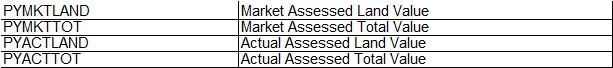
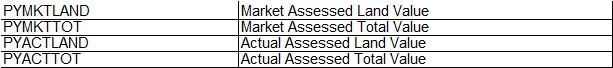
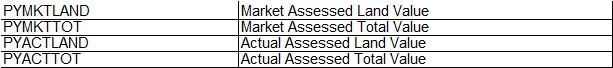
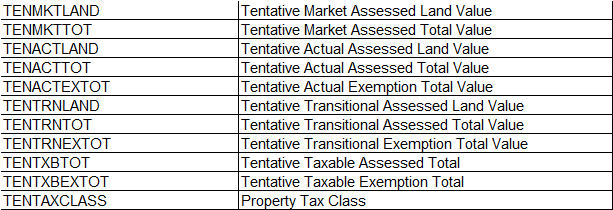
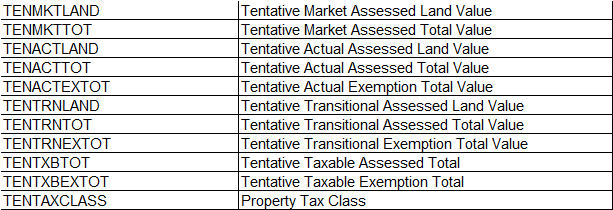
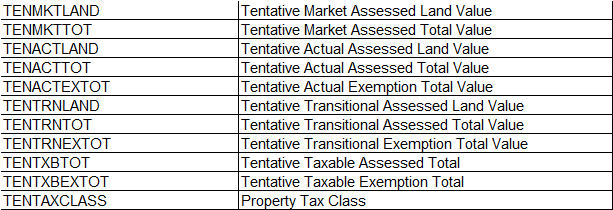
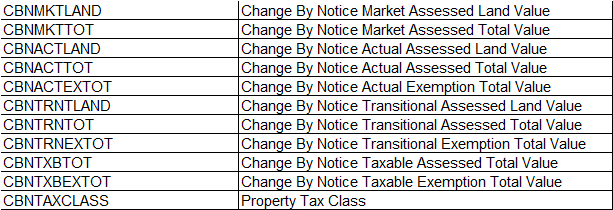
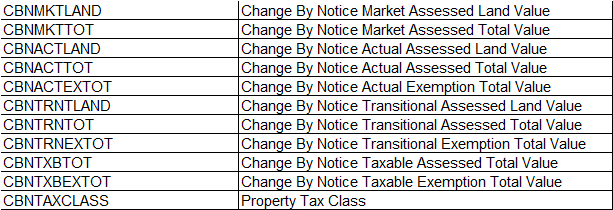
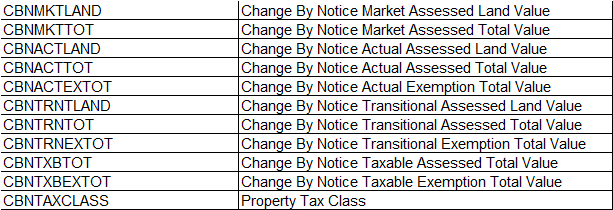
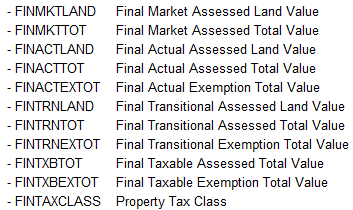
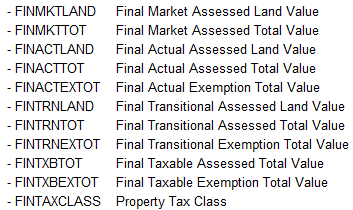
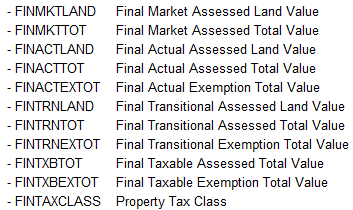
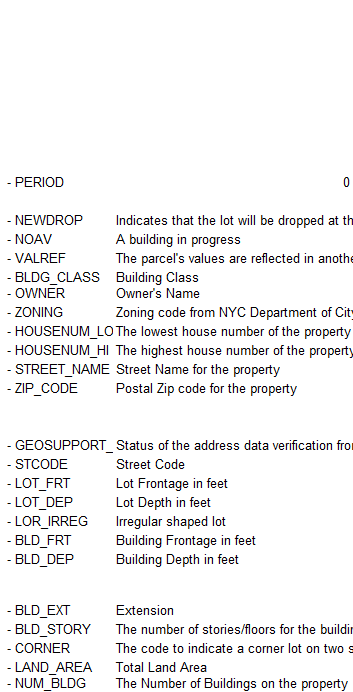
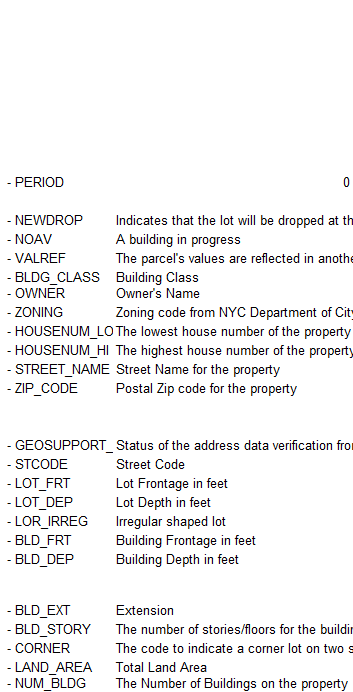
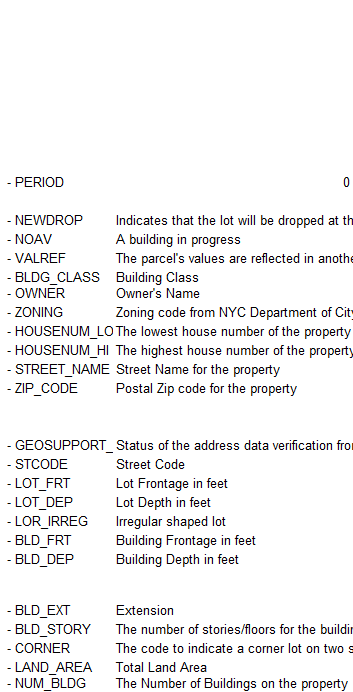
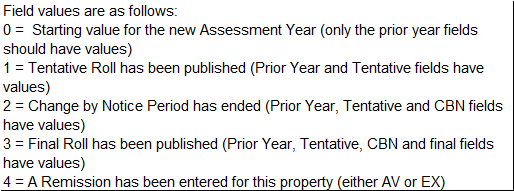
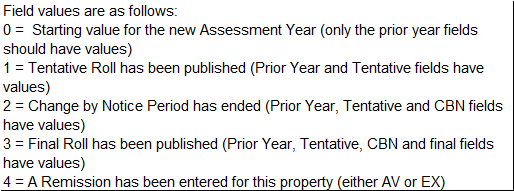
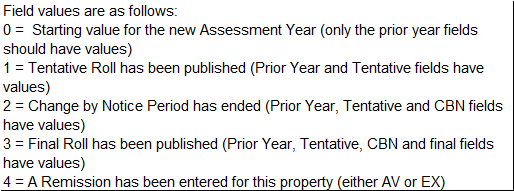

In [6]:


# define the categorical for OHE later
cat_cols = ['RECORD','BBLE','B','BLOCK','LOT','EASEMENT','OWNER','BLDGCL','TAXCLASS','EXT','EXCD1','STADDR','ZIP','EXMPTCL','EXCD2','PERIOD','YEAR','VALTYPE']

# define the numeric cols
num_cols = list(set(df_raw.columns.tolist()) - set(cat_cols))

df = df_raw.copy()
df

,BBLE,B,BLOCK,LOT,EASEMENT,OWNER,BLDGCL,TAXCLASS,LTFRONT,LTDEPTH,EXT,STORIES,FULLVAL,AVLAND,AVTOT,EXLAND,EXTOT,EXCD1,STADDR,ZIP,EXMPTCL,BLDFRONT,BLDDEPTH,AVLAND2,AVTOT2,EXLAND2,EXTOT2,EXCD2,PERIOD,YEAR,VALTYPE
0,1000010010,1,1,10,NaN,UNITED STATES OF AMER,Y4,4,198,0,NaN,NaN,304042000,96228900,136818900,96228900,136818900,"4,500",1 GOVERNORS ISLAND,"10,004",X3,0,0,"81,732,780","120,846,780","81,732,780","120,846,780",NaN,FINAL,2010/11,AC-TR
1,1000010101,1,1,101,NaN,U S GOVT LAND & BLDGS,P7,4,500,1046,NaN,NaN,21400000,4225500,9630000,4225500,9630000,"4,600",1 LIBERTY ISLAND,"10,004",X3,0,0,"3,775,500","8,613,000","3,775,500","8,613,000",NaN,FINAL,2010/11,AC-TR
2,1000010201,1,1,201,NaN,U S GOVT LAND & BLDGS,Z9,4,27,0,NaN,NaN,193800000,14310000,87210000,14310000,87210000,"4,600",1 ELLIS ISLAND,"10,004",X3,0,0,"11,111,400","80,690,400","11,111,400","80,690,400",NaN,FINAL,2010/11,AC-TR
3,1000020001,1,2,1,NaN,DEPT OF GENERAL SERVI,Y7,4,709,564,E,3,104686000,39008700,47108700,39008700,47108700,"2,191",MARGINAL STREET,"10,004",X1,709,564,"32,321,790","40,179,510","32,321,790","40,179,510",NaN,FINAL,2010/11,AC-TR
4,1000020023,1,2,23,NaN,DEPARTMENT OF BUSINES,T2,4,793,551,NaN,2,39200000,15255000,17640000,15255000,17640000,"2,191",PIER 6,"10,004",X1,85,551,"13,644,000","15,750,000","13,644,000","15,750,000",NaN,FINAL,2010/11,AC-TR
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1048570,5060270026,5,6027,26,NaN,HASAN DJUKANOVIC,A9,1,18,70,NaN,2,257000,7981,12820,1620,1620,"1,017",1946 ARTHUR KILL ROAD,"10,312",NaN,18,28,NaN,NaN,NaN,NaN,NaN,FINAL,2010/11,AC-TR
1048571,5060270027,5,6027,27,NaN,GRACE G BUONO,A9,1,24,70,NaN,2,275100,9341,14042,0,0,NaN,1948 ARTHUR KILL ROAD,"10,312",NaN,24,24,NaN,NaN,NaN,NaN,NaN,FINAL,2010/11,AC-TR
1048572,5060270028,5,6027,28,NaN,WALTER ACIERTO,A5,1,24,70,NaN,2,275100,9341,14042,1620,1620,"1,017",1950 ARTHUR KILL ROAD,"10,312",NaN,24,24,NaN,NaN,NaN,NaN,NaN,FINAL,2010/11,AC-TR
1048573,5060270029,5,6027,29,NaN,RICHARD P. DEVLIN,A5,1,18,70,NaN,2,257000,7981,12820,1620,1620,"1,017",1952 ARTHUR KILL ROAD,"10,312",NaN,18,28,NaN,NaN,NaN,NaN,NaN,FINAL,2010/11,AC-TR


## EDA on categorical features

**ZIP** will likely be one of the most influencial features, so let's examine it for NULL values

In [7]:
zip_nan_count = df['ZIP'].isna().sum()
print(f"Count of NaN in ZIP features: {zip_nan_count:,}")
print(f"Percentage of missing ZIP codes: {zip_nan_count/len(df):0.1%}")

Count of NaN in ZIP features: 26,356
Percentage of missing ZIP codes: 2.5%


In [8]:
# The New York City Boroughs:
# Categorical; Borough Code:
#   1 = Manhattan
#   2 = Bronx
#   3 = Brooklyn
#   4 = Queens
#   5 = Staten Island
df['B'].value_counts()

B
4    358046
3    323243
1    146221
5    113780
2    107285
Name: count, dtype: int64

In [9]:
# EASEMENT Categorical; Valid Easement Codes:
#   Blank = No Easement
#   A = Air Rights
#   B = Non-Air Rights
#   E = Land Easement
#   F thru M = Used when property has more than one easements
#   N = Non-Transit
#   P = Piers
#   R = Railroads
#   S = Street
#   U = U.S. Government
df['EASEMENT'].value_counts()

EASEMENT
E    3603
F     265
G      95
H      30
N      17
I      14
J       7
K       4
L       3
M       2
P       2
U       1
Name: count, dtype: int64

In [10]:
# Haven't found a definition for these categories
df['TAXCLASS'].value_counts()

TAXCLASS
1     643774
2     188592
4     102281
2A     40558
1B     22193
1A     20899
2B     13962
2C     10795
3       4546
1C       946
1D        29
Name: count, dtype: int64

In [11]:
# This has 200 categorical values. 
df['BLDGCL'].value_counts()

BLDGCL
R4    139879
A1    119340
A5     92896
B1     84054
B2     73156
       ...  
I2         4
I3         4
H7         3
E6         1
Y5         1
Name: count, Length: 200, dtype: int64

In [12]:
# YEAR can be dropped, this dataset is a single year
df['YEAR'].value_counts()

YEAR
2010/11    1048575
Name: count, dtype: int64

In [13]:
# VALTYPE can be dropped, it's a single value "AC-TR"
df['VALTYPE'].value_counts()

VALTYPE
AC-TR    1048575
Name: count, dtype: int64

In [14]:
# PERIOD can be dropped, it's a single value "FINAL"
df['PERIOD'].value_counts()

PERIOD
FINAL    1048575
Name: count, dtype: int64

In [15]:
# EXCD1 appears to be categorical, it's an exemption code
df['EXCD1'].value_counts()

EXCD1
1,017    414222
1,010     48322
1,015     30849
5,113     23842
1,920     17594
          ...  
4,650         1
1,606         1
1,562         1
1,841         1
1,992         1
Name: count, Length: 129, dtype: int64

In [16]:
# EXCD2 appears to be categorical, it's an exemption code
df['EXCD2'].value_counts()

EXCD2
1,017    64223
1,015    12038
5,112     6867
1,019     3034
1,920     2961
1,200      875
1,101      493
5,129      227
1,986       34
1,022       31
1,985       19
1,604       13
5,109       11
1,021        8
7,160        7
1,523        7
2,280        7
5,111        6
5,114        6
2,310        6
5,113        6
2,152        4
5,110        3
1,501        3
1,023        3
5,130        3
3,390        3
1,504        3
1,605        2
2,500        2
1,602        2
1,404        2
1,603        2
1,521        2
5,104        2
1,850        2
2,232        1
2,350        1
1,011        1
2,134        1
4,500        1
1,402        1
2,262        1
5,101        1
1,930        1
3,410        1
1,891        1
1,102        1
2,202        1
2,201        1
1,522        1
2,231        1
2,132        1
2,151        1
5,116        1
6,800        1
1,505        1
1,401        1
5,108        1
6,320        1
Name: count, dtype: int64

In [17]:
# A massive categorical set of the owners
df['OWNER'].value_counts()

OWNER
PARKCHESTER PRESERVAT    6021
PARKS AND RECREATION     3358
DCAS                     2053
HOUSING PRESERVATION     1900
CITY OF NEW YORK         1189
                         ... 
TREVOR R BAILEY             1
MATHELIER, MARTHA           1
LEON DOUGLAS                1
ROBERTSON, LYNDEL           1
LLERENA ROCIO A             1
Name: count, Length: 847053, dtype: int64

In [18]:
# Extensions categorical, 3 text values
#   E = Extension
#   G = Garage
#   EG = Extension and Garage
df['EXT'].value_counts()

EXT
G     261865
E      49253
EG     37798
Name: count, dtype: int64

In [19]:
df['ZIP'].value_counts()

ZIP
10,314    24605
11,234    20001
10,462    16905
10,306    16576
11,236    15678
          ...  
11,241        1
11,005        1
10,162        1
11,371        1
11,359        1
Name: count, Length: 196, dtype: int64

In [20]:
# exempt class, text categorical
df['EXMPTCL'].value_counts()

EXMPTCL
X1    6494
X5    5158
X7     818
X6     760
X2     665
X4     438
X8     289
X3     260
X9     105
VI       1
KI       1
A9       1
R4       1
5        1
Name: count, dtype: int64

In [21]:
# drop the single value features determined above in EDA
cat_cols = set(cat_cols) - set(['PERIOD','VALTYPE','YEAR'])
df.drop(columns=['PERIOD','VALTYPE','YEAR'])



,BBLE,B,BLOCK,LOT,EASEMENT,OWNER,BLDGCL,TAXCLASS,LTFRONT,LTDEPTH,EXT,STORIES,FULLVAL,AVLAND,AVTOT,EXLAND,EXTOT,EXCD1,STADDR,ZIP,EXMPTCL,BLDFRONT,BLDDEPTH,AVLAND2,AVTOT2,EXLAND2,EXTOT2,EXCD2
0,1000010010,1,1,10,NaN,UNITED STATES OF AMER,Y4,4,198,0,NaN,NaN,304042000,96228900,136818900,96228900,136818900,"4,500",1 GOVERNORS ISLAND,"10,004",X3,0,0,"81,732,780","120,846,780","81,732,780","120,846,780",NaN
1,1000010101,1,1,101,NaN,U S GOVT LAND & BLDGS,P7,4,500,1046,NaN,NaN,21400000,4225500,9630000,4225500,9630000,"4,600",1 LIBERTY ISLAND,"10,004",X3,0,0,"3,775,500","8,613,000","3,775,500","8,613,000",NaN
2,1000010201,1,1,201,NaN,U S GOVT LAND & BLDGS,Z9,4,27,0,NaN,NaN,193800000,14310000,87210000,14310000,87210000,"4,600",1 ELLIS ISLAND,"10,004",X3,0,0,"11,111,400","80,690,400","11,111,400","80,690,400",NaN
3,1000020001,1,2,1,NaN,DEPT OF GENERAL SERVI,Y7,4,709,564,E,3,104686000,39008700,47108700,39008700,47108700,"2,191",MARGINAL STREET,"10,004",X1,709,564,"32,321,790","40,179,510","32,321,790","40,179,510",NaN
4,1000020023,1,2,23,NaN,DEPARTMENT OF BUSINES,T2,4,793,551,NaN,2,39200000,15255000,17640000,15255000,17640000,"2,191",PIER 6,"10,004",X1,85,551,"13,644,000","15,750,000","13,644,000","15,750,000",NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1048570,5060270026,5,6027,26,NaN,HASAN DJUKANOVIC,A9,1,18,70,NaN,2,257000,7981,12820,1620,1620,"1,017",1946 ARTHUR KILL ROAD,"10,312",NaN,18,28,NaN,NaN,NaN,NaN,NaN
1048571,5060270027,5,6027,27,NaN,GRACE G BUONO,A9,1,24,70,NaN,2,275100,9341,14042,0,0,NaN,1948 ARTHUR KILL ROAD,"10,312",NaN,24,24,NaN,NaN,NaN,NaN,NaN
1048572,5060270028,5,6027,28,NaN,WALTER ACIERTO,A5,1,24,70,NaN,2,275100,9341,14042,1620,1620,"1,017",1950 ARTHUR KILL ROAD,"10,312",NaN,24,24,NaN,NaN,NaN,NaN,NaN
1048573,5060270029,5,6027,29,NaN,RICHARD P. DEVLIN,A5,1,18,70,NaN,2,257000,7981,12820,1620,1620,"1,017",1952 ARTHUR KILL ROAD,"10,312",NaN,18,28,NaN,NaN,NaN,NaN,NaN


## EDA on numeric features

In [22]:
# Examine the variance to see if anything needs to be log scaled
num_cols.sort()
df[num_cols].var()

AVLAND      16,816,193,915,834
AVLAND2     38,432,431,266,817
AVTOT       48,319,264,672,884
AVTOT2     136,659,969,073,056
BLDDEPTH                 1,852
BLDFRONT                 1,281
EXLAND      16,195,229,079,964
EXLAND2    117,776,409,842,393
EXTOT       43,273,786,744,258
EXTOT2     260,170,707,779,329
FULLVAL    136,958,500,226,635
LTDEPTH                  5,697
LTFRONT                  5,437
STORIES                     71
dtype: float64

# Data Imputation for key features


## Imputation for ZIP
ZIP code will likely be one of the most influencial features, so let's examine it for NULL values and replace them with something suitable. 


In [23]:
# Copy the staddr field and strip the address number from it.
# Note this also removes some numeric street designations like "1 STREET", but we can catch those with the BLOCK later
df['STADDR_temp'] = df['STADDR']
df['STADDR_temp'] = df['STADDR_temp'].str.lstrip('1234567890. ')
df.head()

,BBLE,B,BLOCK,LOT,EASEMENT,OWNER,BLDGCL,TAXCLASS,LTFRONT,LTDEPTH,EXT,STORIES,FULLVAL,AVLAND,AVTOT,EXLAND,EXTOT,EXCD1,STADDR,ZIP,EXMPTCL,BLDFRONT,BLDDEPTH,AVLAND2,AVTOT2,EXLAND2,EXTOT2,EXCD2,PERIOD,YEAR,VALTYPE,STADDR_temp
0,1000010010,1,1,10,NaN,UNITED STATES OF AMER,Y4,4,198,0,NaN,NaN,304042000,96228900,136818900,96228900,136818900,"4,500",1 GOVERNORS ISLAND,"10,004",X3,0,0,"81,732,780","120,846,780","81,732,780","120,846,780",NaN,FINAL,2010/11,AC-TR,GOVERNORS ISLAND
1,1000010101,1,1,101,NaN,U S GOVT LAND & BLDGS,P7,4,500,1046,NaN,NaN,21400000,4225500,9630000,4225500,9630000,"4,600",1 LIBERTY ISLAND,"10,004",X3,0,0,"3,775,500","8,613,000","3,775,500","8,613,000",NaN,FINAL,2010/11,AC-TR,LIBERTY ISLAND
2,1000010201,1,1,201,NaN,U S GOVT LAND & BLDGS,Z9,4,27,0,NaN,NaN,193800000,14310000,87210000,14310000,87210000,"4,600",1 ELLIS ISLAND,"10,004",X3,0,0,"11,111,400","80,690,400","11,111,400","80,690,400",NaN,FINAL,2010/11,AC-TR,ELLIS ISLAND
3,1000020001,1,2,1,NaN,DEPT OF GENERAL SERVI,Y7,4,709,564,E,3,104686000,39008700,47108700,39008700,47108700,"2,191",MARGINAL STREET,"10,004",X1,709,564,"32,321,790","40,179,510","32,321,790","40,179,510",NaN,FINAL,2010/11,AC-TR,MARGINAL STREET
4,1000020023,1,2,23,NaN,DEPARTMENT OF BUSINES,T2,4,793,551,NaN,2,39200000,15255000,17640000,15255000,17640000,"2,191",PIER 6,"10,004",X1,85,551,"13,644,000","15,750,000","13,644,000","15,750,000",NaN,FINAL,2010/11,AC-TR,PIER 6


In [24]:
df_temp = df.copy() # copy df2 into another dataframe to alter the data fields; this is a throwaway dataframe
f_zip = lambda x: x.mode()[0] if not x.mode().empty else np.nan # This is a lambda function to be used with the transform method on the pandas dataframe
df_temp['STADDR_temp2'] = df_temp['STADDR_temp'].fillna('empty') # fill the NaN values with a dummy value 

# Group by B, BLOCK, STADDR_temp2, then find the mode for the ZIP
df_temp['ZIP2'] = df_temp['ZIP'].fillna(df_temp.groupby(['B','BLOCK','STADDR_temp2'])['ZIP'].transform(f_zip)) # produced 11,057 NaN
print(df_temp['ZIP2'].isna().sum())

11057


In [25]:
# Group by B, BLOCK, then find the mode for the ZIP
df_temp['ZIP3'] = df_temp['ZIP2'].fillna(df_temp.groupby(['B','BLOCK'])['ZIP2'].transform(f_zip)) # produced 1,696 NaN after ZIP2 with STADDR_temp2 
print(df_temp['ZIP3'].isna().sum())

1696


In [26]:
# Group by B, STADDR_temp2, then find the mode for the ZIP
df_temp['ZIP4'] = df_temp['ZIP3'].fillna(df_temp.groupby(['B','STADDR_temp2'])['ZIP3'].transform(f_zip)) # produced 173 NaN after ZIP3 with BLOCK 
print(df_temp['ZIP4'].isna().sum())

173


In [27]:
# Group by B, BLOCK, then find the mode for the ZIP
df_temp['ZIP5'] = df_temp['ZIP4'].fillna(df_temp.groupby(['B','BLOCK'])['ZIP4'].transform(f_zip)) # produced 90 NaN after ZIP4 with STADDR_temp2 
print(df_temp['ZIP5'].isna().sum())

90


In [28]:
# Group by B, then find the mode for the ZIP
df_temp['ZIP6'] = df_temp['ZIP5'].fillna(df_temp.groupby(['B'])['ZIP5'].transform(f_zip)) # No more NaN values
print(df_temp['ZIP6'].isna().sum())

0


In [29]:
# Copy the fully imputated ZIP column back to the original spot
df['ZIP'] = df_temp['ZIP6']

# drop the STDADDR_tmp col now that we're done with it
df.drop(columns='STADDR_temp', inplace=True)
df.head()

,BBLE,B,BLOCK,LOT,EASEMENT,OWNER,BLDGCL,TAXCLASS,LTFRONT,LTDEPTH,EXT,STORIES,FULLVAL,AVLAND,AVTOT,EXLAND,EXTOT,EXCD1,STADDR,ZIP,EXMPTCL,BLDFRONT,BLDDEPTH,AVLAND2,AVTOT2,EXLAND2,EXTOT2,EXCD2,PERIOD,YEAR,VALTYPE
0,1000010010,1,1,10,NaN,UNITED STATES OF AMER,Y4,4,198,0,NaN,NaN,304042000,96228900,136818900,96228900,136818900,"4,500",1 GOVERNORS ISLAND,"10,004",X3,0,0,"81,732,780","120,846,780","81,732,780","120,846,780",NaN,FINAL,2010/11,AC-TR
1,1000010101,1,1,101,NaN,U S GOVT LAND & BLDGS,P7,4,500,1046,NaN,NaN,21400000,4225500,9630000,4225500,9630000,"4,600",1 LIBERTY ISLAND,"10,004",X3,0,0,"3,775,500","8,613,000","3,775,500","8,613,000",NaN,FINAL,2010/11,AC-TR
2,1000010201,1,1,201,NaN,U S GOVT LAND & BLDGS,Z9,4,27,0,NaN,NaN,193800000,14310000,87210000,14310000,87210000,"4,600",1 ELLIS ISLAND,"10,004",X3,0,0,"11,111,400","80,690,400","11,111,400","80,690,400",NaN,FINAL,2010/11,AC-TR
3,1000020001,1,2,1,NaN,DEPT OF GENERAL SERVI,Y7,4,709,564,E,3,104686000,39008700,47108700,39008700,47108700,"2,191",MARGINAL STREET,"10,004",X1,709,564,"32,321,790","40,179,510","32,321,790","40,179,510",NaN,FINAL,2010/11,AC-TR
4,1000020023,1,2,23,NaN,DEPARTMENT OF BUSINES,T2,4,793,551,NaN,2,39200000,15255000,17640000,15255000,17640000,"2,191",PIER 6,"10,004",X1,85,551,"13,644,000","15,750,000","13,644,000","15,750,000",NaN,FINAL,2010/11,AC-TR


## Imputation for STORIES
The original group did a similar process for as the ZIP to fill in the missing values with inferred values

In [30]:
print(f"Missing STORIES values : {df['STORIES'].isna().sum():,} which is {df['STORIES'].isna().sum()/len(df):.0%} of the dataset")

Missing STORIES values : 52,142 which is 5% of the dataset


In [31]:
df_temp = df[['B','STORIES','ZIP','BLDGCL','BLOCK','TAXCLASS']].copy() # copy df into another dataframe to alter the data fields; this is a temp dataframe
f_stories = lambda x: x.median() if x.count() >= 5 else np.nan # This is a lambda function to be used with the transform method on the pandas dataframe

# Group by ZIP, BLDGCL, BLOCK, then find the median for STORIES if there's at least 5 records in the grouping
df_temp['STORIES2'] = df_temp['STORIES'].fillna(df_temp.groupby(['ZIP','BLDGCL','BLOCK'])['STORIES'].transform(f_stories)) # produced 50,114 NaN
df_temp['STORIES2'].isna().sum()

50114

In [32]:
# Group by ZIP, BLDGCL, then find the median for STORIES if there's at least 5 records in the grouping
df_temp['STORIES3'] = df_temp['STORIES2'].fillna(df_temp.groupby(['ZIP','BLDGCL'])['STORIES2'].transform(f_stories)) # produced 43,295 NaN
df_temp['STORIES3'].isna().sum()

43295

In [33]:
# Group by ZIP, TAXCLASS, then find the median for STORIES if there's at least 5 records in the grouping
df_temp['STORIES4'] = df_temp['STORIES3'].fillna(df_temp.groupby(['ZIP','TAXCLASS'])['STORIES3'].transform(f_stories)) # produced 26,766 NaN
df_temp['STORIES4'].isna().sum()

26766

In [34]:
# Group by B, BLDGCL, then find the median for STORIES if there's at least 5 records in the grouping
df_temp['STORIES5'] = df_temp['STORIES4'].fillna(df_temp.groupby(['B','BLDGCL'])['STORIES4'].transform(f_stories)) # produced 26,734 NaN
df_temp['STORIES5'].isna().sum()

26734

3rd lambda function (I skipped the 2nd one from the original since it's unnecessary for reproduction of results)

Changed the lambda function to use the most common value (mode)

In [35]:
# This is a lambda function to be used with the transform method on the pandas dataframe
f_stories_alt2 = lambda x: x.mode()[0] if not x.mode().empty else np.nan # This is a lambda function to be used with the transform method on the pandas dataframe

In [36]:
# Group by BLDGCL, then find the mode for STORIES
df_temp['STORIES7'] = df_temp['STORIES5'].fillna(df_temp.groupby(['BLDGCL'])['STORIES5'].transform(f_stories_alt2)) # produced 2607 NaN
df_temp['STORIES7'].isna().sum()

2607

In [37]:
# Group by TAXCLASS, then find the mode for STORIES
df_temp['STORIES8'] = df_temp['STORIES7'].fillna(df_temp.groupby(['TAXCLASS'])['STORIES7'].transform(f_stories_alt2)) # no more NaN values
df_temp['STORIES8'].isna().sum()

0

In [38]:
# Copy the fully imputated STORIES data field into df2
df['STORIES'] = df_temp['STORIES8']
df.head()

,BBLE,B,BLOCK,LOT,EASEMENT,OWNER,BLDGCL,TAXCLASS,LTFRONT,LTDEPTH,EXT,STORIES,FULLVAL,AVLAND,AVTOT,EXLAND,EXTOT,EXCD1,STADDR,ZIP,EXMPTCL,BLDFRONT,BLDDEPTH,AVLAND2,AVTOT2,EXLAND2,EXTOT2,EXCD2,PERIOD,YEAR,VALTYPE
0,1000010010,1,1,10,NaN,UNITED STATES OF AMER,Y4,4,198,0,NaN,50,304042000,96228900,136818900,96228900,136818900,"4,500",1 GOVERNORS ISLAND,"10,004",X3,0,0,"81,732,780","120,846,780","81,732,780","120,846,780",NaN,FINAL,2010/11,AC-TR
1,1000010101,1,1,101,NaN,U S GOVT LAND & BLDGS,P7,4,500,1046,NaN,50,21400000,4225500,9630000,4225500,9630000,"4,600",1 LIBERTY ISLAND,"10,004",X3,0,0,"3,775,500","8,613,000","3,775,500","8,613,000",NaN,FINAL,2010/11,AC-TR
2,1000010201,1,1,201,NaN,U S GOVT LAND & BLDGS,Z9,4,27,0,NaN,50,193800000,14310000,87210000,14310000,87210000,"4,600",1 ELLIS ISLAND,"10,004",X3,0,0,"11,111,400","80,690,400","11,111,400","80,690,400",NaN,FINAL,2010/11,AC-TR
3,1000020001,1,2,1,NaN,DEPT OF GENERAL SERVI,Y7,4,709,564,E,3,104686000,39008700,47108700,39008700,47108700,"2,191",MARGINAL STREET,"10,004",X1,709,564,"32,321,790","40,179,510","32,321,790","40,179,510",NaN,FINAL,2010/11,AC-TR
4,1000020023,1,2,23,NaN,DEPARTMENT OF BUSINES,T2,4,793,551,NaN,2,39200000,15255000,17640000,15255000,17640000,"2,191",PIER 6,"10,004",X1,85,551,"13,644,000","15,750,000","13,644,000","15,750,000",NaN,FINAL,2010/11,AC-TR


Data Imputation for property values
Note : I think it may be better to just drop the missing valuations, as the whole point of the exercise is to find valuations that are basically outliers, this doesn't contribute anything to the analysis

In [39]:
value_cols = ["FULLVAL","AVLAND","AVTOT"]

for i in value_cols:
    x = df[i].eq(0).sum()
    print(f"Missing {i} values: {x:,} which is {x/len(df[i]):.0%}")

Missing FULLVAL values: 12,762 which is 1%
Missing AVLAND values: 12,764 which is 1%
Missing AVTOT values: 12,762 which is 1%


In [40]:
# Copy the values to a working dataframe and swap zeroes with NaN
df_temp = df[value_cols+["ZIP","TAXCLASS","BLDGCL"]].copy()
df_temp[value_cols]=df_temp[value_cols].replace({0:np.nan})

## Imputation for Property Valuations

/tmp/ipykernel_24/632352966.py:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(temp['FULLVAL'], bins=100, kde=False)


Text(0, 0.5, 'Count')

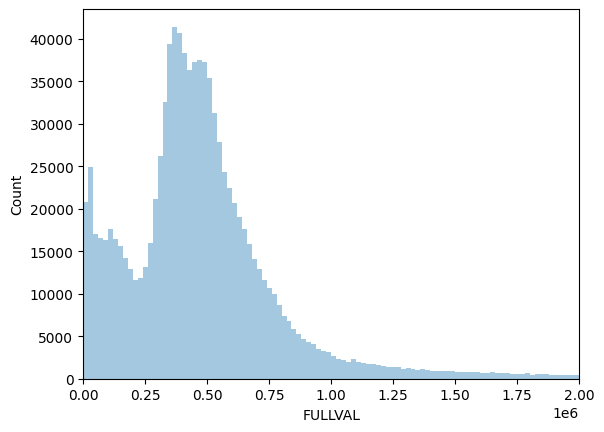

In [41]:
# Lambda function for substituting NaN
f_fullval = lambda x:x.median() if x.count()>=5 else np.nan

# original distribution of FullVall
xhigh = 2000000
plt.xlim(0, xhigh)
temp = df_temp[df_temp['FULLVAL'] <= xhigh]
sns.distplot(temp['FULLVAL'], bins=100, kde=False)
plt.ylabel('Count')


In [42]:
# This group consists of three sub-groups namely ZIP, TAX CLASS, and Building Class. We fill with the median of that group as the distribution is skewed.
df_temp['FULLVAL2']=df_temp['FULLVAL'].fillna(df_temp.groupby(["ZIP","TAXCLASS","BLDGCL"])['FULLVAL'].transform(f_fullval))
df_temp['FULLVAL2'].isnull().value_counts()

FULLVAL2
False    1038165
True       10410
Name: count, dtype: int64

In [43]:
# This group consists of two broader sub-groups namely ZIP and TAX CLASS, dropped Buidling Class.
df_temp["FULLVAL3"]=df_temp['FULLVAL2'].fillna(df_temp.groupby(["ZIP","TAXCLASS"])['FULLVAL2'].transform(f_fullval))
df_temp['FULLVAL3'].isnull().value_counts()

FULLVAL3
False    1044224
True        4351
Name: count, dtype: int64

In [44]:
# This group consists of grouping by ZIP only
df_temp["FULLVAL4"]=df_temp['FULLVAL3'].fillna(df_temp.groupby(["ZIP"])['FULLVAL3'].transform(f_fullval)) 
df_temp['FULLVAL4'].isnull().value_counts()

FULLVAL4
False    1048574
True           1
Name: count, dtype: int64

In [45]:
# Finally, grouping by TAXCLASS only
df_temp["FULLVAL5"]=df_temp['FULLVAL4'].fillna(df_temp.groupby(["TAXCLASS"])['FULLVAL4'].transform(f_fullval)) 
# All NA values removed
df_temp['FULLVAL5'].isnull().value_counts()

FULLVAL5
False    1048575
Name: count, dtype: int64

/tmp/ipykernel_24/3915945619.py:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(temp['FULLVAL5'], bins=100, kde=False)


Text(0, 0.5, 'Count')

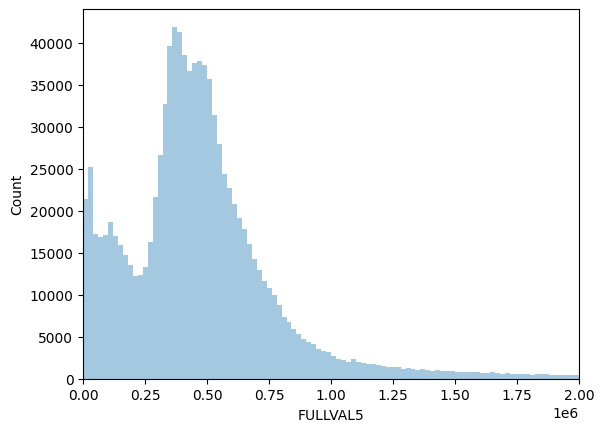

In [46]:
# Final distribution of FullVal after filling NA values
xhigh = 2000000
plt.xlim(0,xhigh)
temp = df_temp[df_temp['FULLVAL5'] <= xhigh]
sns.distplot(temp['FULLVAL5'], bins=100, kde=False)
plt.ylabel('Count')

/tmp/ipykernel_24/1040395403.py:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(temp['AVLAND'],bins=50, kde=False)


Text(0, 0.5, 'Count')

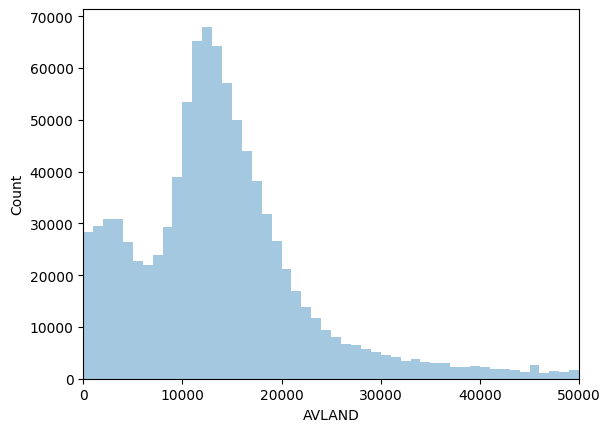

In [47]:
# Original Distribution of AVLAND
xhigh = 50000
plt.xlim(0,xhigh)
temp = df_temp[df_temp['AVLAND'] <= xhigh]
sns.distplot(temp['AVLAND'],bins=50, kde=False)
plt.ylabel('Count')

In [48]:
# This group consists of three sub-groups namely ZIP, TAX CLASS, and Building Class. We fill with the median of that group as the distribution is skewed.
df_temp['AVLAND2']=df_temp['AVLAND'].fillna(df_temp.groupby(["ZIP","TAXCLASS","BLDGCL"])['AVLAND'].transform(f_fullval))
#Filled 2489 NA values from 13007 NA values
df_temp['AVLAND2'].isnull().value_counts()

AVLAND2
False    1038165
True       10410
Name: count, dtype: int64

In [49]:
# Similar to the Full Value, grouping by ZIP and Tax class first
df_temp['AVLAND3']=df_temp['AVLAND2'].fillna(df_temp.groupby(["ZIP","TAXCLASS"])['AVLAND2'].transform(f_fullval))
# Grouping by ZIP
df_temp['AVLAND4']=df_temp['AVLAND3'].fillna(df_temp.groupby(["ZIP"])['AVLAND3'].transform(f_fullval))
# Grouping by Taxclass only
df_temp['AVLAND5']=df_temp['AVLAND4'].fillna(df_temp.groupby(["TAXCLASS"])['AVLAND4'].transform(f_fullval))
df_temp['AVLAND5'].isnull().value_counts()
# All NA values filled

AVLAND5
False    1048575
Name: count, dtype: int64

/tmp/ipykernel_24/1526088987.py:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(temp['AVLAND5'],bins=50, kde=False)


Text(0, 0.5, 'Count')

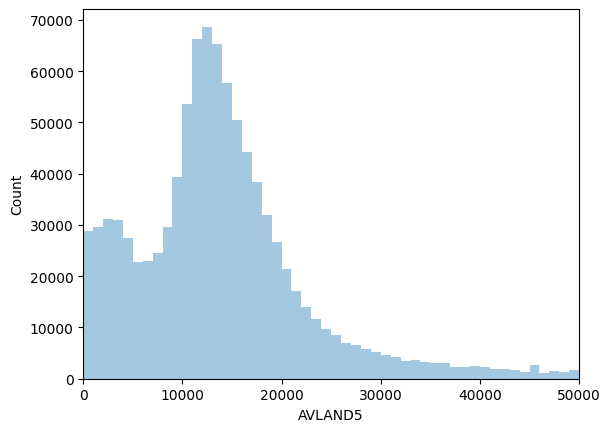

In [50]:
# Final distribution of FullVal after filling NA values
xhigh = 50000
plt.xlim(0,xhigh)
temp = df_temp[df_temp['AVLAND5'] <= xhigh]
sns.distplot(temp['AVLAND5'],bins=50, kde=False)
plt.ylabel('Count')

/tmp/ipykernel_24/335668917.py:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot( temp['AVTOT'], bins=50, kde=False )


Text(0, 0.5, 'Count')

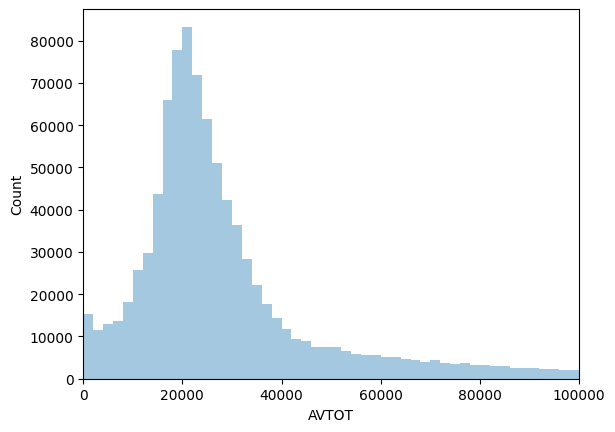

In [51]:
# Original distribution of AVTOT
xhigh = 100000
plt.xlim(0, xhigh)
temp = df_temp[ df_temp['AVTOT'] <= xhigh ]
sns.distplot( temp['AVTOT'], bins=50, kde=False )
plt.ylabel('Count')

In [52]:
# This group consists of three sub-groups namely ZIP, TAX CLASS, and Building Class. We fill with the median of that group as the distribution is skewed.
df_temp['AVTOT2']=df_temp['AVTOT'].fillna(df_temp.groupby(["ZIP","TAXCLASS","BLDGCL"])['AVTOT'].transform(f_fullval))

In [53]:
# Similar to the Full Value, grouping by ZIP and Tax class first
df_temp['AVTOT3'] = df_temp['AVTOT2'].fillna(df_temp.groupby(["ZIP","TAXCLASS"])['AVTOT2'].transform(f_fullval))
# Grouping by ZIP
df_temp['AVTOT4'] = df_temp['AVTOT3'].fillna(df_temp.groupby(["ZIP"])['AVTOT3'].transform(f_fullval))
# Grouping by Taxclass only
df_temp['AVTOT5'] = df_temp['AVTOT4'].fillna(df_temp.groupby(["TAXCLASS"])['AVTOT4'].transform(f_fullval))

/tmp/ipykernel_24/3094543609.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(temp['AVTOT5'], bins=50, kde=False)


Text(0, 0.5, 'Count')

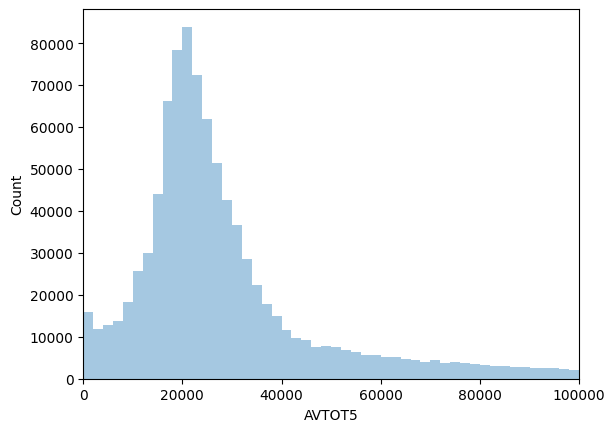

In [54]:
xhigh = 100000
plt.xlim(0,xhigh)
temp = df_temp[df_temp['AVTOT5'] <= xhigh]
sns.distplot(temp['AVTOT5'], bins=50, kde=False)
plt.ylabel('Count')
     

In [55]:
# Dropping Unfilled Columns
d1 = df_temp.drop(["FULLVAL","FULLVAL2","FULLVAL3","FULLVAL4","AVLAND","AVLAND2","AVLAND3","AVLAND4","AVTOT","AVTOT2","AVTOT3","AVTOT4"],axis=1)

In [56]:
# Renaming the columns back to original names
d1 = d1.rename(columns={"FULLVAL5":"FULLVAL","AVLAND5":"AVLAND","AVTOT5":"AVTOT"})

# Assign the inferred values back to the original dataset
for i in value_cols:
    df[i] = d1[i]

df

,BBLE,B,BLOCK,LOT,EASEMENT,OWNER,BLDGCL,TAXCLASS,LTFRONT,LTDEPTH,EXT,STORIES,FULLVAL,AVLAND,AVTOT,EXLAND,EXTOT,EXCD1,STADDR,ZIP,EXMPTCL,BLDFRONT,BLDDEPTH,AVLAND2,AVTOT2,EXLAND2,EXTOT2,EXCD2,PERIOD,YEAR,VALTYPE
0,1000010010,1,1,10,NaN,UNITED STATES OF AMER,Y4,4,198,0,NaN,50,"304,042,000","96,228,900","136,818,900",96228900,136818900,"4,500",1 GOVERNORS ISLAND,"10,004",X3,0,0,"81,732,780","120,846,780","81,732,780","120,846,780",NaN,FINAL,2010/11,AC-TR
1,1000010101,1,1,101,NaN,U S GOVT LAND & BLDGS,P7,4,500,1046,NaN,50,"21,400,000","4,225,500","9,630,000",4225500,9630000,"4,600",1 LIBERTY ISLAND,"10,004",X3,0,0,"3,775,500","8,613,000","3,775,500","8,613,000",NaN,FINAL,2010/11,AC-TR
2,1000010201,1,1,201,NaN,U S GOVT LAND & BLDGS,Z9,4,27,0,NaN,50,"193,800,000","14,310,000","87,210,000",14310000,87210000,"4,600",1 ELLIS ISLAND,"10,004",X3,0,0,"11,111,400","80,690,400","11,111,400","80,690,400",NaN,FINAL,2010/11,AC-TR
3,1000020001,1,2,1,NaN,DEPT OF GENERAL SERVI,Y7,4,709,564,E,3,"104,686,000","39,008,700","47,108,700",39008700,47108700,"2,191",MARGINAL STREET,"10,004",X1,709,564,"32,321,790","40,179,510","32,321,790","40,179,510",NaN,FINAL,2010/11,AC-TR
4,1000020023,1,2,23,NaN,DEPARTMENT OF BUSINES,T2,4,793,551,NaN,2,"39,200,000","15,255,000","17,640,000",15255000,17640000,"2,191",PIER 6,"10,004",X1,85,551,"13,644,000","15,750,000","13,644,000","15,750,000",NaN,FINAL,2010/11,AC-TR
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1048570,5060270026,5,6027,26,NaN,HASAN DJUKANOVIC,A9,1,18,70,NaN,2,"257,000","7,981","12,820",1620,1620,"1,017",1946 ARTHUR KILL ROAD,"10,312",NaN,18,28,NaN,NaN,NaN,NaN,NaN,FINAL,2010/11,AC-TR
1048571,5060270027,5,6027,27,NaN,GRACE G BUONO,A9,1,24,70,NaN,2,"275,100","9,341","14,042",0,0,NaN,1948 ARTHUR KILL ROAD,"10,312",NaN,24,24,NaN,NaN,NaN,NaN,NaN,FINAL,2010/11,AC-TR
1048572,5060270028,5,6027,28,NaN,WALTER ACIERTO,A5,1,24,70,NaN,2,"275,100","9,341","14,042",1620,1620,"1,017",1950 ARTHUR KILL ROAD,"10,312",NaN,24,24,NaN,NaN,NaN,NaN,NaN,FINAL,2010/11,AC-TR
1048573,5060270029,5,6027,29,NaN,RICHARD P. DEVLIN,A5,1,18,70,NaN,2,"257,000","7,981","12,820",1620,1620,"1,017",1952 ARTHUR KILL ROAD,"10,312",NaN,18,28,NaN,NaN,NaN,NaN,NaN,FINAL,2010/11,AC-TR


## Imputation for Property Sizes

In [57]:
size_cols = ["LTFRONT","LTDEPTH","BLDFRONT","BLDDEPTH"]
df_temp = df[size_cols + ["ZIP","TAXCLASS","BLDGCL","B"]].copy()
df_temp

,LTFRONT,LTDEPTH,BLDFRONT,BLDDEPTH,ZIP,TAXCLASS,BLDGCL,B
0,198,0,0,0,"10,004",4,Y4,1
1,500,1046,0,0,"10,004",4,P7,1
2,27,0,0,0,"10,004",4,Z9,1
3,709,564,709,564,"10,004",4,Y7,1
4,793,551,85,551,"10,004",4,T2,1
...,...,...,...,...,...,...,...,...
1048570,18,70,18,28,"10,312",1,A9,5
1048571,24,70,24,24,"10,312",1,A9,5
1048572,24,70,24,24,"10,312",1,A5,5
1048573,18,70,18,28,"10,312",1,A5,5


In [58]:
#check how many null value and 0 in each attribute
for i in size_cols:
    print(f"{i}:")
    print(f"  Null Value Number Counts : {df_temp[i].isnull().sum():,}")
    print(f"  Zero Value Counts : {df_temp[i].eq(0).sum():,}")

LTFRONT:
  Null Value Number Counts : 0
  Zero Value Counts : 168,867
LTDEPTH:
  Null Value Number Counts : 0
  Zero Value Counts : 169,888
BLDFRONT:
  Null Value Number Counts : 0
  Zero Value Counts : 224,661
BLDDEPTH:
  Null Value Number Counts : 0
  Zero Value Counts : 224,699


In [59]:
# function for getting the mode of the group
# mode can be empty, or have multiple values, so return NaN if empty, and the first value if multiple
f_sizemode = lambda x:x.mode(dropna=True)[0] if not x.mode(dropna=True).empty else pd.NA

In [60]:
# this replaces all the zeros with NaN, and then we can just calc the mode which ignores NaN
for i in size_cols:
    new_col = i+"1"
    df_temp[i] = df_temp[i].replace(0, pd.NA)
    df_temp[new_col] = df_temp[i].fillna(df_temp.groupby(['ZIP','BLDGCL'])[i].transform(f_sizemode))
    
df_temp

,LTFRONT,LTDEPTH,BLDFRONT,BLDDEPTH,ZIP,TAXCLASS,BLDGCL,B,LTFRONT1,LTDEPTH1,BLDFRONT1,BLDDEPTH1
0,198,<NA>,<NA>,<NA>,"10,004",4,Y4,1,198,<NA>,<NA>,<NA>
1,500,1046,<NA>,<NA>,"10,004",4,P7,1,500,1046,34,63
2,27,<NA>,<NA>,<NA>,"10,004",4,Z9,1,27,177,37,227
3,709,564,709,564,"10,004",4,Y7,1,709,564,709,564
4,793,551,85,551,"10,004",4,T2,1,793,551,85,551
...,...,...,...,...,...,...,...,...,...,...,...,...
1048570,18,70,18,28,"10,312",1,A9,5,18,70,18,28
1048571,24,70,24,24,"10,312",1,A9,5,24,70,24,24
1048572,24,70,24,24,"10,312",1,A5,5,24,70,24,24
1048573,18,70,18,28,"10,312",1,A5,5,18,70,18,28


In [61]:
#check how many null values now
for i in size_cols:
    new_col = i+"1"
    print(f"{new_col}")
    print(f"  Null Value Number Counts : {df_temp[new_col].isnull().sum():,}")
    print(f"  Zero Value Counts : {df_temp[new_col].eq(0).sum():,}")

LTFRONT1
  Null Value Number Counts : 16,122
  Zero Value Counts : 0
LTDEPTH1
  Null Value Number Counts : 17,859
  Zero Value Counts : 0
BLDFRONT1
  Null Value Number Counts : 70,941
  Zero Value Counts : 0
BLDDEPTH1
  Null Value Number Counts : 70,944
  Zero Value Counts : 0


In [62]:
# this replaces all the zeros with NaN, and then we can just calc the mode which ignores NaN
for i in size_cols:
    prior_col = i+"1"
    new_col = i+"2"
    df_temp[new_col] = df_temp[prior_col].fillna(df_temp.groupby(['ZIP'])[prior_col].transform(f_sizemode))
    
df_temp

/tmp/ipykernel_24/3491323156.py:5: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_temp[new_col] = df_temp[prior_col].fillna(df_temp.groupby(['ZIP'])[prior_col].transform(f_sizemode))
/tmp/ipykernel_24/3491323156.py:5: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_temp[new_col] = df_temp[prior_col].fillna(df_temp.groupby(['ZIP'])[prior_col].transform(f_sizemode))


,LTFRONT,LTDEPTH,BLDFRONT,BLDDEPTH,ZIP,TAXCLASS,BLDGCL,B,LTFRONT1,LTDEPTH1,BLDFRONT1,BLDDEPTH1,LTFRONT2,LTDEPTH2,BLDFRONT2,BLDDEPTH2
0,198,<NA>,<NA>,<NA>,"10,004",4,Y4,1,198,<NA>,<NA>,<NA>,198,53,132,115
1,500,1046,<NA>,<NA>,"10,004",4,P7,1,500,1046,34,63,500,1046,34,63
2,27,<NA>,<NA>,<NA>,"10,004",4,Z9,1,27,177,37,227,27,177,37,227
3,709,564,709,564,"10,004",4,Y7,1,709,564,709,564,709,564,709,564
4,793,551,85,551,"10,004",4,T2,1,793,551,85,551,793,551,85,551
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1048570,18,70,18,28,"10,312",1,A9,5,18,70,18,28,18,70,18,28
1048571,24,70,24,24,"10,312",1,A9,5,24,70,24,24,24,70,24,24
1048572,24,70,24,24,"10,312",1,A5,5,24,70,24,24,24,70,24,24
1048573,18,70,18,28,"10,312",1,A5,5,18,70,18,28,18,70,18,28


In [63]:
#check how many null values now
for i in size_cols:
    new_col = i+"2"
    print(f"{new_col}")
    print(f"  Null Value Number Counts : {df_temp[new_col].isnull().sum():,}")
    print(f"  Zero Value Counts : {df_temp[new_col].eq(0).sum():,}")

LTFRONT2
  Null Value Number Counts : 0
  Zero Value Counts : 0
LTDEPTH2
  Null Value Number Counts : 0
  Zero Value Counts : 0
BLDFRONT2
  Null Value Number Counts : 192
  Zero Value Counts : 0
BLDDEPTH2
  Null Value Number Counts : 192
  Zero Value Counts : 0


In [64]:
# this replaces all the zeros with NaN, and then we can just calc the mode which ignores NaN
for i in size_cols:
    prior_col = i+"2"
    new_col = i+"3"
    df_temp[new_col] = df_temp[prior_col].fillna(df_temp.groupby(['B'])[prior_col].transform(f_sizemode))
    
df_temp

/tmp/ipykernel_24/121198065.py:5: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_temp[new_col] = df_temp[prior_col].fillna(df_temp.groupby(['B'])[prior_col].transform(f_sizemode))
/tmp/ipykernel_24/121198065.py:5: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_temp[new_col] = df_temp[prior_col].fillna(df_temp.groupby(['B'])[prior_col].transform(f_sizemode))


,LTFRONT,LTDEPTH,BLDFRONT,BLDDEPTH,ZIP,TAXCLASS,BLDGCL,B,LTFRONT1,LTDEPTH1,BLDFRONT1,BLDDEPTH1,LTFRONT2,LTDEPTH2,BLDFRONT2,BLDDEPTH2,LTFRONT3,LTDEPTH3,BLDFRONT3,BLDDEPTH3
0,198,<NA>,<NA>,<NA>,"10,004",4,Y4,1,198,<NA>,<NA>,<NA>,198,53,132,115,198,53,132,115
1,500,1046,<NA>,<NA>,"10,004",4,P7,1,500,1046,34,63,500,1046,34,63,500,1046,34,63
2,27,<NA>,<NA>,<NA>,"10,004",4,Z9,1,27,177,37,227,27,177,37,227,27,177,37,227
3,709,564,709,564,"10,004",4,Y7,1,709,564,709,564,709,564,709,564,709,564,709,564
4,793,551,85,551,"10,004",4,T2,1,793,551,85,551,793,551,85,551,793,551,85,551
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1048570,18,70,18,28,"10,312",1,A9,5,18,70,18,28,18,70,18,28,18,70,18,28
1048571,24,70,24,24,"10,312",1,A9,5,24,70,24,24,24,70,24,24,24,70,24,24
1048572,24,70,24,24,"10,312",1,A5,5,24,70,24,24,24,70,24,24,24,70,24,24
1048573,18,70,18,28,"10,312",1,A5,5,18,70,18,28,18,70,18,28,18,70,18,28


In [65]:
#check how many null values now
for i in size_cols:
    new_col = i+"3"
    print(f"{new_col}")
    print(f"  Null Value Number Counts : {df_temp[new_col].isnull().sum():,}")
    print(f"  Zero Value Counts : {df_temp[new_col].eq(0).sum():,}")

LTFRONT3
  Null Value Number Counts : 0
  Zero Value Counts : 0
LTDEPTH3
  Null Value Number Counts : 0
  Zero Value Counts : 0
BLDFRONT3
  Null Value Number Counts : 0
  Zero Value Counts : 0
BLDDEPTH3
  Null Value Number Counts : 0
  Zero Value Counts : 0


In [66]:
# Copy the imputed valuations back to the main dataframe
for i in size_cols:
    new_col = i+"3"
    df[i] = df_temp[new_col]

df

,BBLE,B,BLOCK,LOT,EASEMENT,OWNER,BLDGCL,TAXCLASS,LTFRONT,LTDEPTH,EXT,STORIES,FULLVAL,AVLAND,AVTOT,EXLAND,EXTOT,EXCD1,STADDR,ZIP,EXMPTCL,BLDFRONT,BLDDEPTH,AVLAND2,AVTOT2,EXLAND2,EXTOT2,EXCD2,PERIOD,YEAR,VALTYPE
0,1000010010,1,1,10,NaN,UNITED STATES OF AMER,Y4,4,198,53,NaN,50,"304,042,000","96,228,900","136,818,900",96228900,136818900,"4,500",1 GOVERNORS ISLAND,"10,004",X3,132,115,"81,732,780","120,846,780","81,732,780","120,846,780",NaN,FINAL,2010/11,AC-TR
1,1000010101,1,1,101,NaN,U S GOVT LAND & BLDGS,P7,4,500,1046,NaN,50,"21,400,000","4,225,500","9,630,000",4225500,9630000,"4,600",1 LIBERTY ISLAND,"10,004",X3,34,63,"3,775,500","8,613,000","3,775,500","8,613,000",NaN,FINAL,2010/11,AC-TR
2,1000010201,1,1,201,NaN,U S GOVT LAND & BLDGS,Z9,4,27,177,NaN,50,"193,800,000","14,310,000","87,210,000",14310000,87210000,"4,600",1 ELLIS ISLAND,"10,004",X3,37,227,"11,111,400","80,690,400","11,111,400","80,690,400",NaN,FINAL,2010/11,AC-TR
3,1000020001,1,2,1,NaN,DEPT OF GENERAL SERVI,Y7,4,709,564,E,3,"104,686,000","39,008,700","47,108,700",39008700,47108700,"2,191",MARGINAL STREET,"10,004",X1,709,564,"32,321,790","40,179,510","32,321,790","40,179,510",NaN,FINAL,2010/11,AC-TR
4,1000020023,1,2,23,NaN,DEPARTMENT OF BUSINES,T2,4,793,551,NaN,2,"39,200,000","15,255,000","17,640,000",15255000,17640000,"2,191",PIER 6,"10,004",X1,85,551,"13,644,000","15,750,000","13,644,000","15,750,000",NaN,FINAL,2010/11,AC-TR
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1048570,5060270026,5,6027,26,NaN,HASAN DJUKANOVIC,A9,1,18,70,NaN,2,"257,000","7,981","12,820",1620,1620,"1,017",1946 ARTHUR KILL ROAD,"10,312",NaN,18,28,NaN,NaN,NaN,NaN,NaN,FINAL,2010/11,AC-TR
1048571,5060270027,5,6027,27,NaN,GRACE G BUONO,A9,1,24,70,NaN,2,"275,100","9,341","14,042",0,0,NaN,1948 ARTHUR KILL ROAD,"10,312",NaN,24,24,NaN,NaN,NaN,NaN,NaN,FINAL,2010/11,AC-TR
1048572,5060270028,5,6027,28,NaN,WALTER ACIERTO,A5,1,24,70,NaN,2,"275,100","9,341","14,042",1620,1620,"1,017",1950 ARTHUR KILL ROAD,"10,312",NaN,24,24,NaN,NaN,NaN,NaN,NaN,FINAL,2010/11,AC-TR
1048573,5060270029,5,6027,29,NaN,RICHARD P. DEVLIN,A5,1,18,70,NaN,2,"257,000","7,981","12,820",1620,1620,"1,017",1952 ARTHUR KILL ROAD,"10,312",NaN,18,28,NaN,NaN,NaN,NaN,NaN,FINAL,2010/11,AC-TR


## Imputation Validation

In [67]:
# Verify Data Imputation Work
for i in df.columns:
    print(f"col {i}; NaN: {df[i].isna().sum()}; Zeros: {df[i].eq(0).sum()}")

col BBLE; NaN: 0; Zeros: 0
col B; NaN: 0; Zeros: 0
col BLOCK; NaN: 0; Zeros: 0
col LOT; NaN: 0; Zeros: 0
col EASEMENT; NaN: 1044532; Zeros: 0
col OWNER; NaN: 31083; Zeros: 0
col BLDGCL; NaN: 0; Zeros: 0
col TAXCLASS; NaN: 0; Zeros: 0
col LTFRONT; NaN: 0; Zeros: 0
col LTDEPTH; NaN: 0; Zeros: 0
col EXT; NaN: 699659; Zeros: 0
col STORIES; NaN: 0; Zeros: 0
col FULLVAL; NaN: 0; Zeros: 0
col AVLAND; NaN: 0; Zeros: 0
col AVTOT; NaN: 0; Zeros: 0
col EXLAND; NaN: 0; Zeros: 484224
col EXTOT; NaN: 0; Zeros: 425999
col EXCD1; NaN: 425933; Zeros: 0
col STADDR; NaN: 641; Zeros: 0
col ZIP; NaN: 0; Zeros: 0
col EXMPTCL; NaN: 1033583; Zeros: 0
col BLDFRONT; NaN: 0; Zeros: 0
col BLDDEPTH; NaN: 0; Zeros: 0
col AVLAND2; NaN: 767609; Zeros: 0
col AVTOT2; NaN: 767603; Zeros: 0
col EXLAND2; NaN: 961900; Zeros: 0
col EXTOT2; NaN: 918642; Zeros: 0
col EXCD2; NaN: 957634; Zeros: 0
col PERIOD; NaN: 0; Zeros: 0
col YEAR; NaN: 0; Zeros: 0
col VALTYPE; NaN: 0; Zeros: 0


# Variable Creation
## Creation of Area Variables

In [68]:
df["LOTAREA"] = df['LTFRONT'] * df['LTDEPTH']
df["BLDAREA"] = df['BLDFRONT'] * df['BLDDEPTH']
df["BLDVOL"] = df['BLDAREA'] * df['STORIES']

In [69]:
df["FULLVAL/LOTAREA"]=df.FULLVAL/df.LOTAREA
df["FULLVAL/BLDAREA"]=df.FULLVAL/df.BLDAREA
df["FULLVAL/BLDVOL"]=df.FULLVAL/df.BLDVOL
df["AVLAND/LOTAREA"]=df.AVLAND/df.LOTAREA
df["AVLAND/BLDAREA"]=df.AVLAND/df.BLDAREA
df["AVLAND/BLDVOL"]=df.AVLAND/df.BLDVOL
df["AVTOT/LOTAREA"]=df.AVTOT/df.LOTAREA
df["AVTOT/BLDAREA"]=df.AVTOT/df.BLDAREA
df["AVTOT/BLDVOL"]=df.AVTOT/df.BLDVOL

df.head()

,BBLE,B,BLOCK,LOT,EASEMENT,OWNER,BLDGCL,TAXCLASS,LTFRONT,LTDEPTH,EXT,STORIES,FULLVAL,AVLAND,AVTOT,EXLAND,EXTOT,EXCD1,STADDR,ZIP,EXMPTCL,BLDFRONT,BLDDEPTH,AVLAND2,AVTOT2,EXLAND2,EXTOT2,EXCD2,PERIOD,YEAR,VALTYPE,LOTAREA,BLDAREA,BLDVOL,FULLVAL/LOTAREA,FULLVAL/BLDAREA,FULLVAL/BLDVOL,AVLAND/LOTAREA,AVLAND/BLDAREA,AVLAND/BLDVOL,AVTOT/LOTAREA,AVTOT/BLDAREA,AVTOT/BLDVOL
0,1000010010,1,1,10,NaN,UNITED STATES OF AMER,Y4,4,198,53,NaN,50,"304,042,000","96,228,900","136,818,900",96228900,136818900,"4,500",1 GOVERNORS ISLAND,"10,004",X3,132,115,"81,732,780","120,846,780","81,732,780","120,846,780",NaN,FINAL,2010/11,AC-TR,10494,15180,"759,000","28,973","20,029",401,"9,170","6,339",127,"13,038","9,013",180
1,1000010101,1,1,101,NaN,U S GOVT LAND & BLDGS,P7,4,500,1046,NaN,50,"21,400,000","4,225,500","9,630,000",4225500,9630000,"4,600",1 LIBERTY ISLAND,"10,004",X3,34,63,"3,775,500","8,613,000","3,775,500","8,613,000",NaN,FINAL,2010/11,AC-TR,523000,2142,"107,100",41,"9,991",200,8,"1,973",39,18,"4,496",90
2,1000010201,1,1,201,NaN,U S GOVT LAND & BLDGS,Z9,4,27,177,NaN,50,"193,800,000","14,310,000","87,210,000",14310000,87210000,"4,600",1 ELLIS ISLAND,"10,004",X3,37,227,"11,111,400","80,690,400","11,111,400","80,690,400",NaN,FINAL,2010/11,AC-TR,4779,8399,"419,950","40,552","23,074",461,"2,994","1,704",34,"18,249","10,383",208
3,1000020001,1,2,1,NaN,DEPT OF GENERAL SERVI,Y7,4,709,564,E,3,"104,686,000","39,008,700","47,108,700",39008700,47108700,"2,191",MARGINAL STREET,"10,004",X1,709,564,"32,321,790","40,179,510","32,321,790","40,179,510",NaN,FINAL,2010/11,AC-TR,399876,399876,"1,199,628",262,262,87,98,98,33,118,118,39
4,1000020023,1,2,23,NaN,DEPARTMENT OF BUSINES,T2,4,793,551,NaN,2,"39,200,000","15,255,000","17,640,000",15255000,17640000,"2,191",PIER 6,"10,004",X1,85,551,"13,644,000","15,750,000","13,644,000","15,750,000",NaN,FINAL,2010/11,AC-TR,436943,46835,"93,670",90,837,418,35,326,163,40,377,188


In [70]:
m = df["FULLVAL/LOTAREA"].mean()
print(df["FULLVAL/LOTAREA"][0])
print(m)
print(df["FULLVAL/LOTAREA"][0]/m)

28972.936916333143
349.8100282888914
82.82477508736766


In [71]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 43 columns):
 #   Column           Non-Null Count    Dtype  
---  ------           --------------    -----  
 0   BBLE             1048575 non-null  object 
 1   B                1048575 non-null  int64  
 2   BLOCK            1048575 non-null  int64  
 3   LOT              1048575 non-null  int64  
 4   EASEMENT         4043 non-null     object 
 5   OWNER            1017492 non-null  object 
 6   BLDGCL           1048575 non-null  object 
 7   TAXCLASS         1048575 non-null  object 
 8   LTFRONT          1048575 non-null  int64  
 9   LTDEPTH          1048575 non-null  int64  
 10  EXT              348916 non-null   object 
 11  STORIES          1048575 non-null  float64
 12  FULLVAL          1048575 non-null  float64
 13  AVLAND           1048575 non-null  float64
 14  AVTOT            1048575 non-null  float64
 15  EXLAND           1048575 non-null  int64  
 16  EXTOT            1

In [72]:
# Creating ZIP3 by taking first 3 digits of ZIP code
df["ZIP3"]=[x[0:3] for x in df.ZIP.astype(str)]

In [73]:
# lambda function to create variables by dividing the 9 normalised variables with the grouped averages 
f_norm_mean = lambda x: x / x.mean()

## Normalization of new features

In [88]:

# Normalize all the new columns
grp_cols = ["ZIP", "ZIP3", "TAXCLASS", "B"]
cols_to_normalize = [
    "FULLVAL/LOTAREA",
    "FULLVAL/BLDAREA",
    "FULLVAL/BLDVOL",
    "AVLAND/LOTAREA",
    "AVLAND/BLDAREA",
    "AVLAND/BLDVOL",
    "AVTOT/LOTAREA",
    "AVTOT/BLDAREA",
    "AVTOT/BLDVOL" ]

for i in grp_cols:
    for j in cols_to_normalize:
        norm_col_name = f"{j}_{i}"
        df[norm_col_name] = df.groupby([i])[j].transform(f_norm_mean)


In [89]:
# Add 9 additional variables by dividing the mean of the full column and not the group
for i in cols_to_normalize:
    m = df[i].mean()
    full_norm_name = f"{i}_FULL"
    df[full_norm_name] = df[i] / m

df.shape

(1048575, 89)

In [90]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 89 columns):
 #   Column                    Non-Null Count    Dtype  
---  ------                    --------------    -----  
 0   BBLE                      1048575 non-null  object 
 1   B                         1048575 non-null  int64  
 2   BLOCK                     1048575 non-null  int64  
 3   LOT                       1048575 non-null  int64  
 4   EASEMENT                  4043 non-null     object 
 5   OWNER                     1017492 non-null  object 
 6   BLDGCL                    1048575 non-null  object 
 7   TAXCLASS                  1048575 non-null  object 
 8   LTFRONT                   1048575 non-null  int64  
 9   LTDEPTH                   1048575 non-null  int64  
 10  EXT                       348916 non-null   object 
 11  STORIES                   1048575 non-null  float64
 12  FULLVAL                   1048575 non-null  float64
 13  AVLAND                    1

## Subsetting the dataframe features for PCA in the next section

In [91]:
df_model = df.iloc[:,44:89].copy()
df_model

,FULLVAL/LOTAREA_ZIP,FULLVAL/BLDAREA_ZIP,FULLVAL/BLDVOL_ZIP,AVLAND/LOTAREA_ZIP,AVLAND/BLDAREA_ZIP,AVLAND/BLDVOL_ZIP,AVTOT/LOTAREA_ZIP,AVTOT/BLDAREA_ZIP,AVTOT/BLDVOL_ZIP,FULLVAL/LOTAREA_ZIP3,FULLVAL/BLDAREA_ZIP3,FULLVAL/BLDVOL_ZIP3,AVLAND/LOTAREA_ZIP3,AVLAND/BLDAREA_ZIP3,AVLAND/BLDVOL_ZIP3,AVTOT/LOTAREA_ZIP3,AVTOT/BLDAREA_ZIP3,AVTOT/BLDVOL_ZIP3,FULLVAL/LOTAREA_TAXCLASS,FULLVAL/BLDAREA_TAXCLASS,FULLVAL/BLDVOL_TAXCLASS,AVLAND/LOTAREA_TAXCLASS,AVLAND/BLDAREA_TAXCLASS,AVLAND/BLDVOL_TAXCLASS,AVTOT/LOTAREA_TAXCLASS,AVTOT/BLDAREA_TAXCLASS,AVTOT/BLDVOL_TAXCLASS,FULLVAL/LOTAREA_B,FULLVAL/BLDAREA_B,FULLVAL/BLDVOL_B,AVLAND/LOTAREA_B,AVLAND/BLDAREA_B,AVLAND/BLDVOL_B,AVTOT/LOTAREA_B,AVTOT/BLDAREA_B,AVTOT/BLDVOL_B,FULLVAL/LOTAREA_FULL,FULLVAL/BLDAREA_FULL,FULLVAL/BLDVOL_FULL,AVLAND/LOTAREA_FULL,AVLAND/BLDAREA_FULL,AVLAND/BLDVOL_FULL,AVTOT/LOTAREA_FULL,AVTOT/BLDAREA_FULL,AVTOT/BLDVOL_FULL
0,77.96,35.28,2.93,159.33,42.60,2.40,84.43,37.15,3.08,77.40,30.77,2.25,253.61,60.84,3.25,132.19,47.88,3.48,129.38,16.80,0.61,225.21,14.62,0.48,129.26,14.66,0.56,79.41,31.79,2.34,263.17,63.96,3.45,136.38,50.02,3.67,82.82,31.23,1.32,831.55,105.42,3.76,418.29,93.07,3.96
1,0.11,17.60,1.46,0.14,13.26,0.75,0.12,18.53,1.54,0.11,15.35,1.12,0.22,18.93,1.01,0.19,23.88,1.73,0.18,8.38,0.30,0.20,4.55,0.15,0.18,7.31,0.28,0.11,15.86,1.17,0.23,19.90,1.08,0.19,24.95,1.83,0.12,15.58,0.66,0.73,32.81,1.17,0.59,46.42,1.97
2,109.12,40.65,3.38,52.03,11.45,0.65,118.18,42.80,3.55,108.33,35.45,2.59,82.82,16.35,0.87,185.02,55.16,4.00,181.08,19.35,0.70,73.54,3.93,0.13,180.92,16.88,0.64,111.15,36.62,2.69,85.94,17.19,0.93,190.88,57.62,4.23,115.93,35.97,1.52,271.54,28.33,1.01,585.47,107.22,4.56
3,0.70,0.46,0.64,1.69,0.66,0.62,0.76,0.49,0.67,0.70,0.40,0.49,2.70,0.94,0.83,1.19,0.63,0.76,1.17,0.22,0.13,2.40,0.23,0.12,1.17,0.19,0.12,0.72,0.42,0.51,2.80,0.98,0.89,1.23,0.65,0.80,0.75,0.41,0.29,8.85,1.62,0.96,3.78,1.22,0.86
4,0.24,1.47,3.06,0.61,2.19,3.09,0.26,1.55,3.22,0.24,1.29,2.35,0.97,3.13,4.18,0.41,2.00,3.63,0.40,0.70,0.63,0.86,0.75,0.62,0.40,0.61,0.58,0.25,1.33,2.44,1.00,3.29,4.44,0.42,2.09,3.84,0.26,1.30,1.38,3.17,5.42,4.83,1.30,3.89,4.14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1048570,1.23,0.97,0.91,1.27,0.72,0.54,1.18,0.77,0.61,1.59,0.93,0.85,1.50,0.39,0.29,1.28,0.46,0.37,0.88,0.73,0.75,1.10,0.88,0.89,1.05,0.83,0.85,1.59,0.93,0.85,1.50,0.39,0.29,1.28,0.46,0.37,0.58,0.80,0.84,0.57,0.26,0.23,0.33,0.26,0.28
1048571,0.99,0.91,0.85,1.12,0.74,0.56,0.97,0.73,0.58,1.28,0.87,0.80,1.31,0.40,0.30,1.05,0.44,0.35,0.71,0.68,0.70,0.96,0.90,0.91,0.86,0.80,0.81,1.28,0.87,0.80,1.31,0.40,0.30,1.05,0.44,0.35,0.47,0.74,0.79,0.50,0.27,0.24,0.27,0.25,0.27
1048572,0.99,0.91,0.85,1.12,0.74,0.56,0.97,0.73,0.58,1.28,0.87,0.80,1.31,0.40,0.30,1.05,0.44,0.35,0.71,0.68,0.70,0.96,0.90,0.91,0.86,0.80,0.81,1.28,0.87,0.80,1.31,0.40,0.30,1.05,0.44,0.35,0.47,0.74,0.79,0.50,0.27,0.24,0.27,0.25,0.27
1048573,1.23,0.97,0.91,1.27,0.72,0.54,1.18,0.77,0.61,1.59,0.93,0.85,1.50,0.39,0.29,1.28,0.46,0.37,0.88,0.73,0.75,1.10,0.88,0.89,1.05,0.83,0.85,1.59,0.93,0.85,1.50,0.39,0.29,1.28,0.46,0.37,0.58,0.80,0.84,0.57,0.26,0.23,0.33,0.26,0.28


# Dimensionality Reduction and Outlier Detection

In [93]:
df.shape

(1048575, 89)

In [94]:
df_model.shape

(1048575, 45)

In [95]:
metrics_df = pd.DataFrame()
metrics_df['Orig Mean'] = df_model.mean()
metrics_df['Orig Var'] = df_model.var()
metrics_df['Orig STD'] = df_model.std()

#print(f"Original Means: {df_model.mean()}")
#print(f"Original Variance: {df_model.var()}")
#print(f"Original Std Dev: {df_model.std()}")

# Normalize the features
model_scaled = preprocessing.scale(df_model)
df_model = pd.DataFrame(model_scaled, columns=df_model.columns)

metrics_df['Norm Mean'] = df_model.mean()
metrics_df['Norm Var'] = df_model.var()
metrics_df['Norm STD'] = df_model.std()

# Verify normalization
#print(f"Normalized Means: {df_model.mean()}")
#print(f"Normalized Variance: {df_model.var()}")
#print(f"Normalized Std Dev: {df_model.std()}")

metrics_df

,Orig Mean,Orig Var,Orig STD,Norm Mean,Norm Var,Norm STD
FULLVAL/LOTAREA_ZIP,1.00,9.86,3.14,0.00,1.00,1.00
FULLVAL/BLDAREA_ZIP,1.00,104.71,10.23,0.00,1.00,1.00
FULLVAL/BLDVOL_ZIP,1.00,139.57,11.81,-0.00,1.00,1.00
AVLAND/LOTAREA_ZIP,1.00,135.89,11.66,-0.00,1.00,1.00
AVLAND/BLDAREA_ZIP,1.00,606.21,24.62,0.00,1.00,1.00
AVLAND/BLDVOL_ZIP,1.00,653.21,25.56,0.00,1.00,1.00
AVTOT/LOTAREA_ZIP,1.00,77.97,8.83,-0.00,1.00,1.00
AVTOT/BLDAREA_ZIP,1.00,432.45,20.80,-0.00,1.00,1.00
AVTOT/BLDVOL_ZIP,1.00,481.11,21.93,0.00,1.00,1.00
FULLVAL/LOTAREA_ZIP3,1.00,63.85,7.99,-0.00,1.00,1.00


In [96]:
df_model.head()

,FULLVAL/LOTAREA_ZIP,FULLVAL/BLDAREA_ZIP,FULLVAL/BLDVOL_ZIP,AVLAND/LOTAREA_ZIP,AVLAND/BLDAREA_ZIP,AVLAND/BLDVOL_ZIP,AVTOT/LOTAREA_ZIP,AVTOT/BLDAREA_ZIP,AVTOT/BLDVOL_ZIP,FULLVAL/LOTAREA_ZIP3,FULLVAL/BLDAREA_ZIP3,FULLVAL/BLDVOL_ZIP3,AVLAND/LOTAREA_ZIP3,AVLAND/BLDAREA_ZIP3,AVLAND/BLDVOL_ZIP3,AVTOT/LOTAREA_ZIP3,AVTOT/BLDAREA_ZIP3,AVTOT/BLDVOL_ZIP3,FULLVAL/LOTAREA_TAXCLASS,FULLVAL/BLDAREA_TAXCLASS,FULLVAL/BLDVOL_TAXCLASS,AVLAND/LOTAREA_TAXCLASS,AVLAND/BLDAREA_TAXCLASS,AVLAND/BLDVOL_TAXCLASS,AVTOT/LOTAREA_TAXCLASS,AVTOT/BLDAREA_TAXCLASS,AVTOT/BLDVOL_TAXCLASS,FULLVAL/LOTAREA_B,FULLVAL/BLDAREA_B,FULLVAL/BLDVOL_B,AVLAND/LOTAREA_B,AVLAND/BLDAREA_B,AVLAND/BLDVOL_B,AVTOT/LOTAREA_B,AVTOT/BLDAREA_B,AVTOT/BLDVOL_B,FULLVAL/LOTAREA_FULL,FULLVAL/BLDAREA_FULL,FULLVAL/BLDVOL_FULL,AVLAND/LOTAREA_FULL,AVLAND/BLDAREA_FULL,AVLAND/BLDVOL_FULL,AVTOT/LOTAREA_FULL,AVTOT/BLDAREA_FULL,AVTOT/BLDVOL_FULL
0,24.51,3.35,0.16,13.58,1.69,0.05,9.45,1.74,0.09,9.56,1.69,0.04,11.87,0.60,0.02,11.82,0.51,0.02,29.74,0.66,-0.01,37.46,0.24,-0.00,28.93,0.50,-0.01,5.84,1.66,0.05,12.22,0.63,0.02,9.98,0.50,0.03,3.78,1.57,0.01,51.84,1.07,0.02,34.71,0.92,0.03
1,-0.28,1.62,0.04,-0.07,0.50,-0.01,-0.10,0.84,0.02,-0.11,0.81,0.00,-0.04,0.18,0.00,-0.07,0.25,0.01,-0.19,0.31,-0.01,-0.13,0.06,-0.01,-0.18,0.23,-0.01,-0.07,0.80,0.01,-0.04,0.19,0.00,-0.06,0.24,0.01,-0.04,0.76,-0.01,-0.02,0.33,0.00,-0.03,0.45,0.01
2,34.44,3.87,0.20,4.38,0.42,-0.01,13.27,2.01,0.12,13.43,1.95,0.06,3.84,0.15,-0.00,16.59,0.59,0.03,41.72,0.77,-0.00,12.12,0.05,-0.01,40.58,0.59,-0.00,8.20,1.92,0.06,3.96,0.16,-0.00,14.00,0.58,0.03,5.31,1.82,0.02,16.89,0.28,0.00,48.62,1.06,0.03
3,-0.09,-0.05,-0.03,0.06,-0.01,-0.02,-0.03,-0.02,-0.02,-0.04,-0.03,-0.02,0.08,-0.00,-0.00,0.02,-0.00,-0.00,0.04,-0.03,-0.01,0.23,-0.01,-0.01,0.04,-0.03,-0.01,-0.02,-0.03,-0.02,0.08,-0.00,-0.00,0.02,-0.00,-0.00,-0.01,-0.03,-0.02,0.49,0.01,-0.00,0.23,0.00,-0.00
4,-0.24,0.05,0.17,-0.03,0.05,0.08,-0.08,0.03,0.10,-0.10,0.02,0.05,-0.00,0.02,0.03,-0.05,0.01,0.03,-0.14,-0.01,-0.00,-0.02,-0.00,-0.00,-0.14,-0.01,-0.01,-0.06,0.02,0.05,0.00,0.02,0.03,-0.04,0.01,0.03,-0.03,0.02,0.01,0.14,0.05,0.03,0.02,0.03,0.03


In [97]:
# Reduce dimensions via PCA
model_pca = PCA().set_output(transform='pandas')
model_pca.fit_transform(X=df_model, y=None)

,pca0,pca1,pca2,pca3,pca4,pca5,pca6,pca7,pca8,pca9,pca10,pca11,pca12,pca13,pca14,pca15,pca16,pca17,pca18,pca19,pca20,pca21,pca22,pca23,pca24,pca25,pca26,pca27,pca28,pca29,pca30,pca31,pca32,pca33,pca34,pca35,pca36,pca37,pca38,pca39,pca40,pca41,pca42,pca43,pca44
0,31.40,68.71,9.36,-21.00,5.77,25.10,11.06,1.99,-14.51,1.02,-2.07,-12.26,9.95,29.78,9.02,-3.16,1.69,5.08,1.77,-1.08,0.77,0.70,-0.18,-1.60,-1.99,0.73,-4.77,7.37,-0.41,-0.07,-0.88,-0.16,-0.19,-0.30,0.08,0.32,-0.22,0.05,-0.06,0.15,0.03,0.01,-0.06,0.02,-0.01
1,1.17,-0.86,-0.15,0.40,-0.86,0.43,0.11,1.40,-0.15,0.15,0.35,-0.58,-0.52,0.04,-0.06,-0.06,0.07,0.03,0.00,-0.07,-0.06,-0.09,0.43,0.19,-0.00,-0.19,0.13,0.15,-0.11,0.15,0.01,-0.00,-0.09,-0.01,-0.00,0.04,0.00,-0.01,-0.04,0.01,-0.04,0.03,0.01,-0.01,0.02
2,26.25,65.29,18.43,-4.77,3.64,32.19,25.29,-4.23,2.28,2.97,-0.43,-25.69,24.69,-0.73,-0.34,1.99,-1.86,-2.24,-3.63,-2.95,-0.20,-0.72,-0.15,0.57,2.77,-0.51,2.69,-4.01,-0.18,-0.68,0.34,1.38,0.32,0.13,0.05,-0.06,0.14,0.08,0.09,0.06,0.05,-0.03,0.01,-0.00,-0.02
3,0.06,0.30,-0.04,-0.13,0.08,-0.00,-0.07,0.01,-0.32,0.00,-0.04,-0.09,0.08,0.35,0.10,-0.02,0.03,0.07,0.03,-0.02,0.03,0.01,-0.01,-0.01,-0.02,0.01,-0.06,0.08,-0.01,-0.01,-0.01,-0.01,-0.00,-0.00,0.00,0.00,-0.00,0.00,-0.00,0.00,0.00,0.00,-0.00,-0.00,-0.00
4,0.11,-0.23,-0.09,0.04,-0.12,-0.09,-0.16,-0.03,-0.20,0.09,-0.07,-0.01,0.04,0.16,-0.03,0.01,0.03,0.02,0.02,-0.00,0.05,0.01,-0.02,0.01,-0.01,0.02,-0.03,0.01,0.00,-0.01,0.01,-0.01,0.00,0.00,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,0.00,0.00,-0.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1048570,-0.01,0.06,0.01,-0.01,0.01,-0.01,-0.00,0.01,0.09,-0.01,0.01,0.04,-0.05,-0.01,-0.00,-0.01,-0.00,-0.03,0.01,-0.02,0.01,-0.00,0.00,-0.00,-0.02,0.00,0.00,0.00,0.02,0.02,-0.00,0.03,0.01,-0.00,-0.00,0.00,0.00,-0.00,0.00,-0.00,-0.00,0.00,0.00,0.00,-0.00
1048571,-0.05,-0.02,-0.01,0.00,0.01,-0.05,-0.03,0.01,0.04,-0.01,0.01,0.04,-0.05,-0.01,-0.00,-0.01,-0.00,-0.02,0.01,-0.02,0.01,-0.00,0.00,-0.00,-0.01,0.00,0.00,-0.00,0.02,0.02,0.00,0.02,0.01,0.00,-0.00,0.00,0.00,-0.00,0.00,-0.00,-0.00,0.00,0.00,0.00,-0.00
1048572,-0.05,-0.02,-0.01,0.00,0.01,-0.05,-0.03,0.01,0.04,-0.01,0.01,0.04,-0.05,-0.01,-0.00,-0.01,-0.00,-0.02,0.01,-0.02,0.01,-0.00,0.00,-0.00,-0.01,0.00,0.00,-0.00,0.02,0.02,0.00,0.02,0.01,0.00,-0.00,0.00,0.00,-0.00,0.00,-0.00,-0.00,0.00,0.00,0.00,-0.00
1048573,-0.01,0.06,0.01,-0.01,0.01,-0.01,-0.00,0.01,0.09,-0.01,0.01,0.04,-0.05,-0.01,-0.00,-0.01,-0.00,-0.03,0.01,-0.02,0.01,-0.00,0.00,-0.00,-0.02,0.00,0.00,0.00,0.02,0.02,-0.00,0.03,0.01,-0.00,-0.00,0.00,0.00,-0.00,0.00,-0.00,-0.00,0.00,0.00,0.00,-0.00


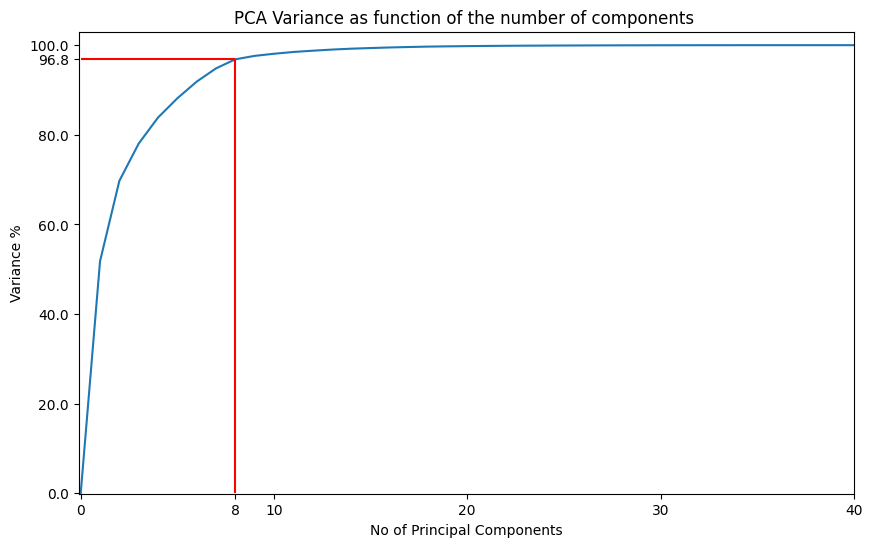

In [98]:
# Amount of variance explained by each component
plot_pca_vecs = 8
pca_all_vecs = model_pca.explained_variance_ratio_
pca_plot_arr = np.zeros(len(pca_all_vecs)+1)
pca_plot_arr[1:] = np.cumsum(pca_all_vecs)
fig, ax = plt.subplots(1, 1, figsize= (10, 6))
p = plt.plot(pca_plot_arr * 100)
plt.title("PCA Variance as function of the number of components ")
plt.xlabel("No of Principal Components")
plt.ylabel("Variance %")

plt.vlines( x = plot_pca_vecs, ymin = 0, ymax = pca_plot_arr[8] * 100, color = 'r')
plt.hlines( y = pca_plot_arr[plot_pca_vecs] * 100, xmin = 0, xmax = plot_pca_vecs, color = 'r' )
plt.xlim(-0.1,)
plt.ylim(-0.1)

# Callout the 8 PCA components on the X axis
xt = ax.get_xticks()
xt = np.append( xt, plot_pca_vecs )
ax.set_xticks(xt)

# Callout the f(8) on the y axis
yt = ax.get_yticks()
yt = np.append(yt, [pca_plot_arr[plot_pca_vecs] * 100])
ax.set_yticks(yt)

plt.xlim([-0.1, 40])
plt.ylim([-0.1, 103])

plt.show()


In [100]:
# Get the number of principal components when variance ratio is at least 95%
var_per = 0.95
np.where(pca_all_vecs.cumsum() > var_per)[0][0]

7

In [101]:
# Percentage of explained variance of first 8 components
pca_plot_arr[plot_pca_vecs] * 100

96.8419296980027

In [102]:
# select the first 8 PC
start_time = dt.datetime.now()

pca_comp = PCA(n_components = 8).set_output(transform='pandas')
X_pca_train = pca_comp.fit_transform(X=df_model, y=None)

finish_time = dt.datetime.now()
print(f"Time to fit PCA components: {finish_time - start_time}")

Time to fit PCA components: 0:00:05.595634


In [103]:
print(f"Dimensions of PCA set: {X_pca_train.shape}")

Dimensions of PCA set: (1048575, 8)


In [104]:
# Amount of variance explained by each component
pca_vari = pca_comp.explained_variance_
pca_vari

array([23.30216942,  8.07534625,  3.73809357,  2.61603329,  1.93256622,
        1.67251443,  1.33133654,  0.9108502 ])

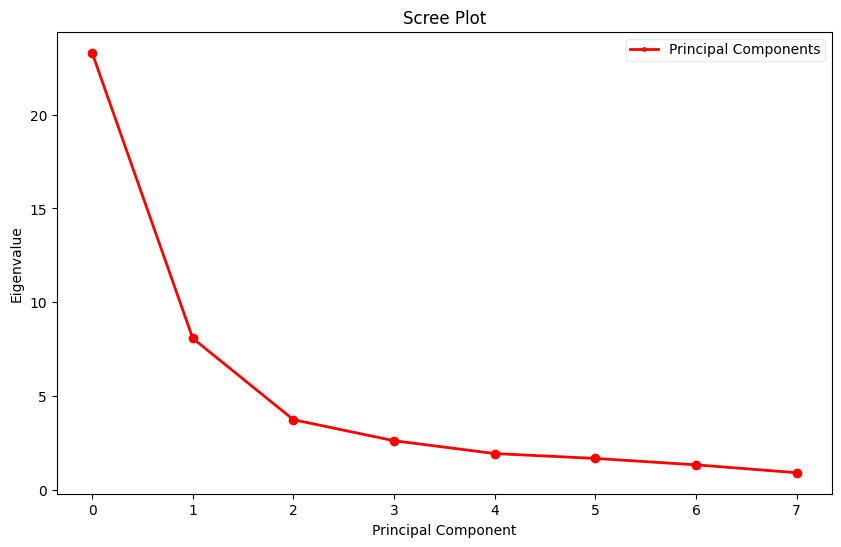

In [105]:
# Scree plot of the variance
fig = plt.figure(figsize=(10,6))
# sing_vals = np.arange(num_vars) + 1
plt.plot(np.arange(0,len(pca_vari)), pca_vari, 'ro-', linewidth=2)
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Eigenvalue')
# I don't like the default legend so I typically make mine like below, e.g.
# with smaller fonts and a bit transparent so I do not cover up data, and make
# it moveable by the viewer in case upper-right is a bad place for it 
leg = plt.legend(['Principal Components'], loc='best', borderpad=0.3, 
                 shadow=False,
                 markerscale=0.4)
leg.get_frame().set_alpha(0.4)
plt.show()

## Z scale the principal components
Input for the autoencoder

In [106]:
X_pca_norm_arr = preprocessing.scale(X_pca_train)

# Verify: means will be zero and std dev with be 1 for each new feature
print('Normalized mean is: ',str(np.isclose(np.mean(X_pca_norm_arr, axis=0),0)-1))
print('Normalized std is: ',str(np.std(X_pca_norm_arr, axis=0)))

Normalized mean is:  [0 0 0 0 0 0 0 0]
Normalized std is:  [1. 1. 1. 1. 1. 1. 1. 1.]


## Score 1: The potential fraud score if any function of these zscores that appear extreme
(Note, this is just model output, this would need extensive additional research to confirm/disprove)

In [107]:
p = 2
# row-wise lp norm of each data point
scores_1 = norm(X_pca_norm_arr, ord = p, axis = 1)
scores_1.shape

(1048575,)

## Score 2
### (a) train an autoencoder with Keras
Basic autoencoder configuration taken from here https://blog.keras.io/building-autoencoders-in-keras.html

In [108]:
# this is the size of our encoded representations
encoding_dim = 5 # number of hidden layer nodes

# this is our input placeholder
input_mat = Input(shape=(X_pca_train.shape[1],))

# "encoded" is the encoded representation of the input
encoded = Dense(encoding_dim, activation='relu')(input_mat)

# "decoded" is the lossy reconstruction of the input
decoded = Dense(X_pca_train.shape[1], activation='sigmoid')(encoded)

# this model maps an input to its reconstruction
autoencoder = Model(input_mat, decoded)

In [109]:
# Let's also create a separate encoder model:

# this model maps an input to its encoded representation
encoder = Model(input_mat, encoded)

# As well as the decoder model: 
# create a placeholder for an encoded (5-dimensional) input
encoded_input = Input(shape=(encoding_dim,))

# retrieve the last layer of the autoencoder model
decoder_layer = autoencoder.layers[-1]

# create the decoder model
decoder = Model(encoded_input, decoder_layer(encoded_input))

# autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')
autoencoder.compile(optimizer='adadelta', loss='mean_squared_error')


In [110]:
# fit the model
no_of_epochs = 5
start_time = dt.datetime.now()
history = autoencoder.fit(x = X_pca_train, y = X_pca_train, batch_size = 1000, epochs = no_of_epochs, validation_split = 0)
print('Keras model fit duration: ', dt.datetime.now() - start_time)

Epoch 1/5
1049/1049 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 4.7851
Epoch 2/5
1049/1049 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 5.8976
Epoch 3/5
1049/1049 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 6.2248
Epoch 4/5
1049/1049 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 5.1030
Epoch 5/5
1049/1049 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 8.7102
Keras model fit duration:  0:00:08.758349


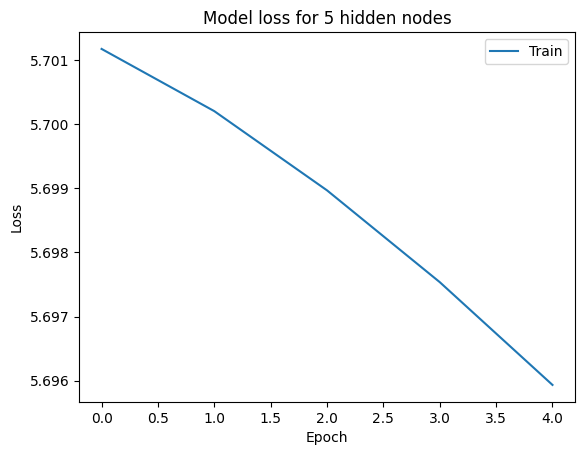

In [111]:
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.title('Model loss for '+str(encoding_dim)+' hidden nodes')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='upper right')
plt.show()


In [112]:
# get autoencoder output (decoder layer output)
start_time = dt.datetime.now()
encoded_out = encoder.predict(X_pca_train)
decoded_out = decoder.predict(encoded_out)
print('duration: ', dt.datetime.now() - start_time)

32768/32768 ━━━━━━━━━━━━━━━━━━━━ 31s 940us/step
32768/32768 ━━━━━━━━━━━━━━━━━━━━ 31s 942us/step
duration:  0:01:27.716993


In [113]:
print('Output layer shape is:',str(decoded_out.shape))

Output layer shape is: (1048575, 8)


### (b) this will create an outlier score as a measure of difference between the original input record and the autoencoder output record

In [121]:
# define the difference between input-output:
auto_enc_diff = X_pca_train - decoded_out # input- output
     
# p defined above
scores_2 = norm(auto_enc_diff, ord = p, axis = 1)
print(f"Using {p}-norm")
print(f"scores_2 shape: {scores_2.shape}")     

Using 2-norm
scores_2 shape: (1048575,)


## Final Combined Score

In [122]:
saved_scores = pd.DataFrame({'Score 1': scores_1, 'Score 2': scores_2})
saved_scores.head()

,Score 1,Score 2
0,36.19,83.03
1,1.70,2.41
2,42.23,82.86
3,0.16,1.37
4,0.20,1.61


In [123]:
saved_scores['Avg'] = saved_scores.mean(axis = 1)
saved_scores['Score 1 Rank'] = saved_scores['Score 1'].rank(ascending = False)
saved_scores['Score 2 Rank'] = saved_scores['Score 2'].rank(ascending=False)
saved_scores['Average Rank'] = saved_scores[['Score 1 Rank','Score 2 Rank']].mean(axis = 1)
saved_scores['Max Rank'] = saved_scores[['Score 1 Rank','Score 2 Rank']].min(axis = 1)
saved_scores_ranked = saved_scores.sort_values(by='Average Rank',ascending=True)
# res_df_filter = res_df_filter.drop(columns='rank_avg')
saved_scores_ranked

,Score 1,Score 2,Avg,Score 1 Rank,Score 2 Rank,Average Rank,Max Rank
632816,"1,001.23","2,600.31","1,800.77",1.00,2.00,1.50,1.00
565392,933.90,"3,319.12","2,126.51",3.00,1.00,2.00,1.00
917942,985.98,"2,114.97","1,550.47",2.00,4.00,3.00,2.00
565390,760.04,"2,313.10","1,536.57",4.00,3.00,3.50,3.00
750816,560.75,810.53,685.64,5.00,7.00,6.00,5.00
...,...,...,...,...,...,...,...
1043587,0.05,1.34,0.69,"1,017,480.00","937,249.00","977,364.50","937,249.00"
1040971,0.05,1.34,0.69,"1,017,853.00","937,069.00","977,461.00","937,069.00"
1037892,0.04,1.35,0.70,"1,026,729.00","928,391.00","977,560.00","928,391.00"
1037895,0.04,1.35,0.70,"1,028,126.50","927,387.50","977,757.00","927,387.50"


In [134]:
# Finding the top 10 outliers in the dataset
max_outliers = 10

out_index = saved_scores.nsmallest(n = max_outliers, columns='Average Rank').index

pd.set_option('display.max_rows', 100)

# outliers on the original dataset
outlier_original_df = df.loc[out_index]
outlier_original_df.T

,632816,565392,917942,565390,126223,750816,565398,585118,585439,248665
BBLE,4018420001,3085900700,4142600001,3085900600,1017540033,4066610005E,3085910100,4004200001,4004590005,2056500001
B,4,3,4,3,1,4,3,4,4,2
BLOCK,1842,8590,14260,8590,1754,6661,8591,420,459,5650
LOT,1,700,1,600,33,5,100,1,5,1
EASEMENT,NaN,NaN,NaN,NaN,NaN,E,NaN,NaN,NaN,NaN
OWNER,"864163 REALTY, LLC",U S GOVERNMENT OWNRD,"LOGAN PROPERTY, INC.",PARKS AND RECREATION,SIX COLUMNS RLTY CORP,M FLAUM,DEPT OF GENERAL SERVI,NEW YORK CITY ECONOMI,11-01 43RD AVENUE REA,PARKS AND RECREATION
BLDGCL,D9,V9,T1,Q1,Z9,V0,V9,O3,H9,Q1
TAXCLASS,2,4,4,4,4,1B,4,4,4,4
LTFRONT,157,117,4910,143,99,1,466,298,94,600
LTDEPTH,95,108,100,128,90,1,1009,402,165,4000


In [135]:
# The columns are the index numbers and the record numbers are just an addition of '1' to the index number
fraud_rec_df45 = df_model.loc[out_index]
fraud_rec_df45.transpose()

,632816,565392,917942,565390,126223,750816,565398,585118,585439,248665
FULLVAL/LOTAREA_ZIP,-0.03,506.77,1.99,17.78,0.14,280.39,6.96,-0.24,0.33,0.18
FULLVAL/BLDAREA_ZIP,300.08,362.09,96.93,374.42,87.64,-0.05,193.36,169.43,182.66,268.27
FULLVAL/BLDVOL_ZIP,445.58,393.99,53.41,407.41,71.77,-0.07,210.41,52.37,113.01,95.13
AVLAND/LOTAREA_ZIP,0.93,849.32,72.09,29.94,0.56,52.86,12.11,0.05,0.08,1.18
AVLAND/BLDAREA_ZIP,256.23,264.57,264.87,270.97,42.56,-0.03,141.30,115.66,18.78,389.57
AVLAND/BLDVOL_ZIP,340.31,261.78,237.95,268.12,38.51,-0.04,139.81,51.08,16.59,197.47
AVTOT/LOTAREA_ZIP,0.42,852.90,137.82,30.33,0.20,33.79,12.13,-0.06,0.34,0.65
AVTOT/BLDAREA_ZIP,272.27,298.26,322.37,308.42,45.83,-0.04,159.29,89.11,96.06,310.19
AVTOT/BLDVOL_ZIP,373.39,295.51,294.75,305.57,40.61,-0.04,157.82,35.70,77.02,162.04
FULLVAL/LOTAREA_ZIP3,-0.10,172.83,0.56,6.05,0.03,23.79,2.36,-0.11,0.01,-0.05
